In [1]:
# Imports
import cv2
import glob
import os.path
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import numpy as np

from scipy.ndimage.measurements import label

from skimage.feature import hog
from skimage import color, exposure
from sklearn.calibration import CalibratedClassifierCV
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle

import features as F
import pipeline as p

%matplotlib inline


In [2]:
# Load Data and Feature engineering.

def LoadData(imagePath):
    images = glob.glob(imagePath)
    data = []

    for image in images:
        data.append(image)
    return data

carTrainDataPath = "./data/vehicles/*/*.png"
carTestDataPath = "./data/vehicles/*/test/*.png"

carsTrain = LoadData(carTrainDataPath)
carsTest = LoadData(carTestDataPath)

notCarPath = "./data/non-vehicles/*/*.png"
notCars = LoadData(notCarPath)

f = F.Features()

carTrainData_features = f.extract_features(carsTrain, color_space='YCrCb')
carTestData_features = f.extract_features(carsTest, color_space='YCrCb')
allcar_features = carTrainData_features + carTestData_features

notcar_features = f.extract_features(notCars, color_space='YCrCb')
rand_state = np.random.randint(0, 100)
notcar_features_train, notcar_features_test = train_test_split(notcar_features, train_size = 0.78, random_state=rand_state)

# Prepare Features.
print("Number of vehicles images: ", len(carTrainData_features), " ", len(carTestData_features), " ", len(allcar_features))
print("Number of non-vehicles images: ", len(notcar_features_train), " ", len(notcar_features_test), " ", len(notcar_features))



Number of vehicles images:  6824   1968   8792
Number of non-vehicles images:  6995   1973   8968


In [3]:
# Train and Save Classifier

# Create an array stack of feature vectors
X = np.vstack((allcar_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)


# Apply the scaler to X
carTrainData_features = X_scaler.transform(carTrainData_features)
carTestData_features = X_scaler.transform(carTestData_features)
notcar_features_train = X_scaler.transform(notcar_features_train)
notcar_features_test = X_scaler.transform(notcar_features_test)

X_train = np.vstack((carTrainData_features, notcar_features_train)).astype(np.float64)                        
y_train = np.hstack((np.ones(len(carTrainData_features)), np.zeros(len(notcar_features_train))))

X_test = np.vstack((carTestData_features, notcar_features_test)).astype(np.float64)                        
y_test = np.hstack((np.ones(len(carTestData_features)), np.zeros(len(notcar_features_test))))

rand_state = np.random.randint(0, 100)
X_train, y_train = shuffle(X_train, y_train, random_state=0)

print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=1.0)
clf = CalibratedClassifierCV(svc)
# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
print('Train Accuracy of SVC = ', round(clf.score(X_train, y_train), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
print('with probability: ', clf.predict_proba(X_test[0:n_predict]))

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
# Save model & scaler
print("Saving models...")
joblib.dump(svc, './models/classifier.pkl')
joblib.dump(clf, './models/calibrated.pkl')
joblib.dump(X_scaler, './models/scaler.pkl')
print("Done!")

Feature vector length: 5388
32.5 Seconds to train SVC...
Test Accuracy of SVC =  0.9817
Train Accuracy of SVC =  1.0
My SVC predicts:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
with probability:  [[  2.55294736e-08   9.99999974e-01]
 [  8.63656095e-04   9.99136344e-01]
 [  1.30768900e-05   9.99986923e-01]
 [  1.75083762e-05   9.99982492e-01]
 [  2.23734889e-05   9.99977627e-01]
 [  8.38148648e-07   9.99999162e-01]
 [  4.02010124e-04   9.99597990e-01]
 [  8.34623107e-05   9.99916538e-01]
 [  1.39043578e-04   9.99860956e-01]
 [  3.21352060e-06   9.99996786e-01]]
0.00378 Seconds to predict 10 labels with SVC
Saving models...
Done!


In [2]:
# Load Models

# Load the classifier model
svc = joblib.load('./models/classifier.pkl')
clf = joblib.load('./models/calibrated.pkl')

# Load the standard scalar model
X_scaler = joblib.load('./models/scaler.pkl')

max_val 1.0
max_val 0.992157


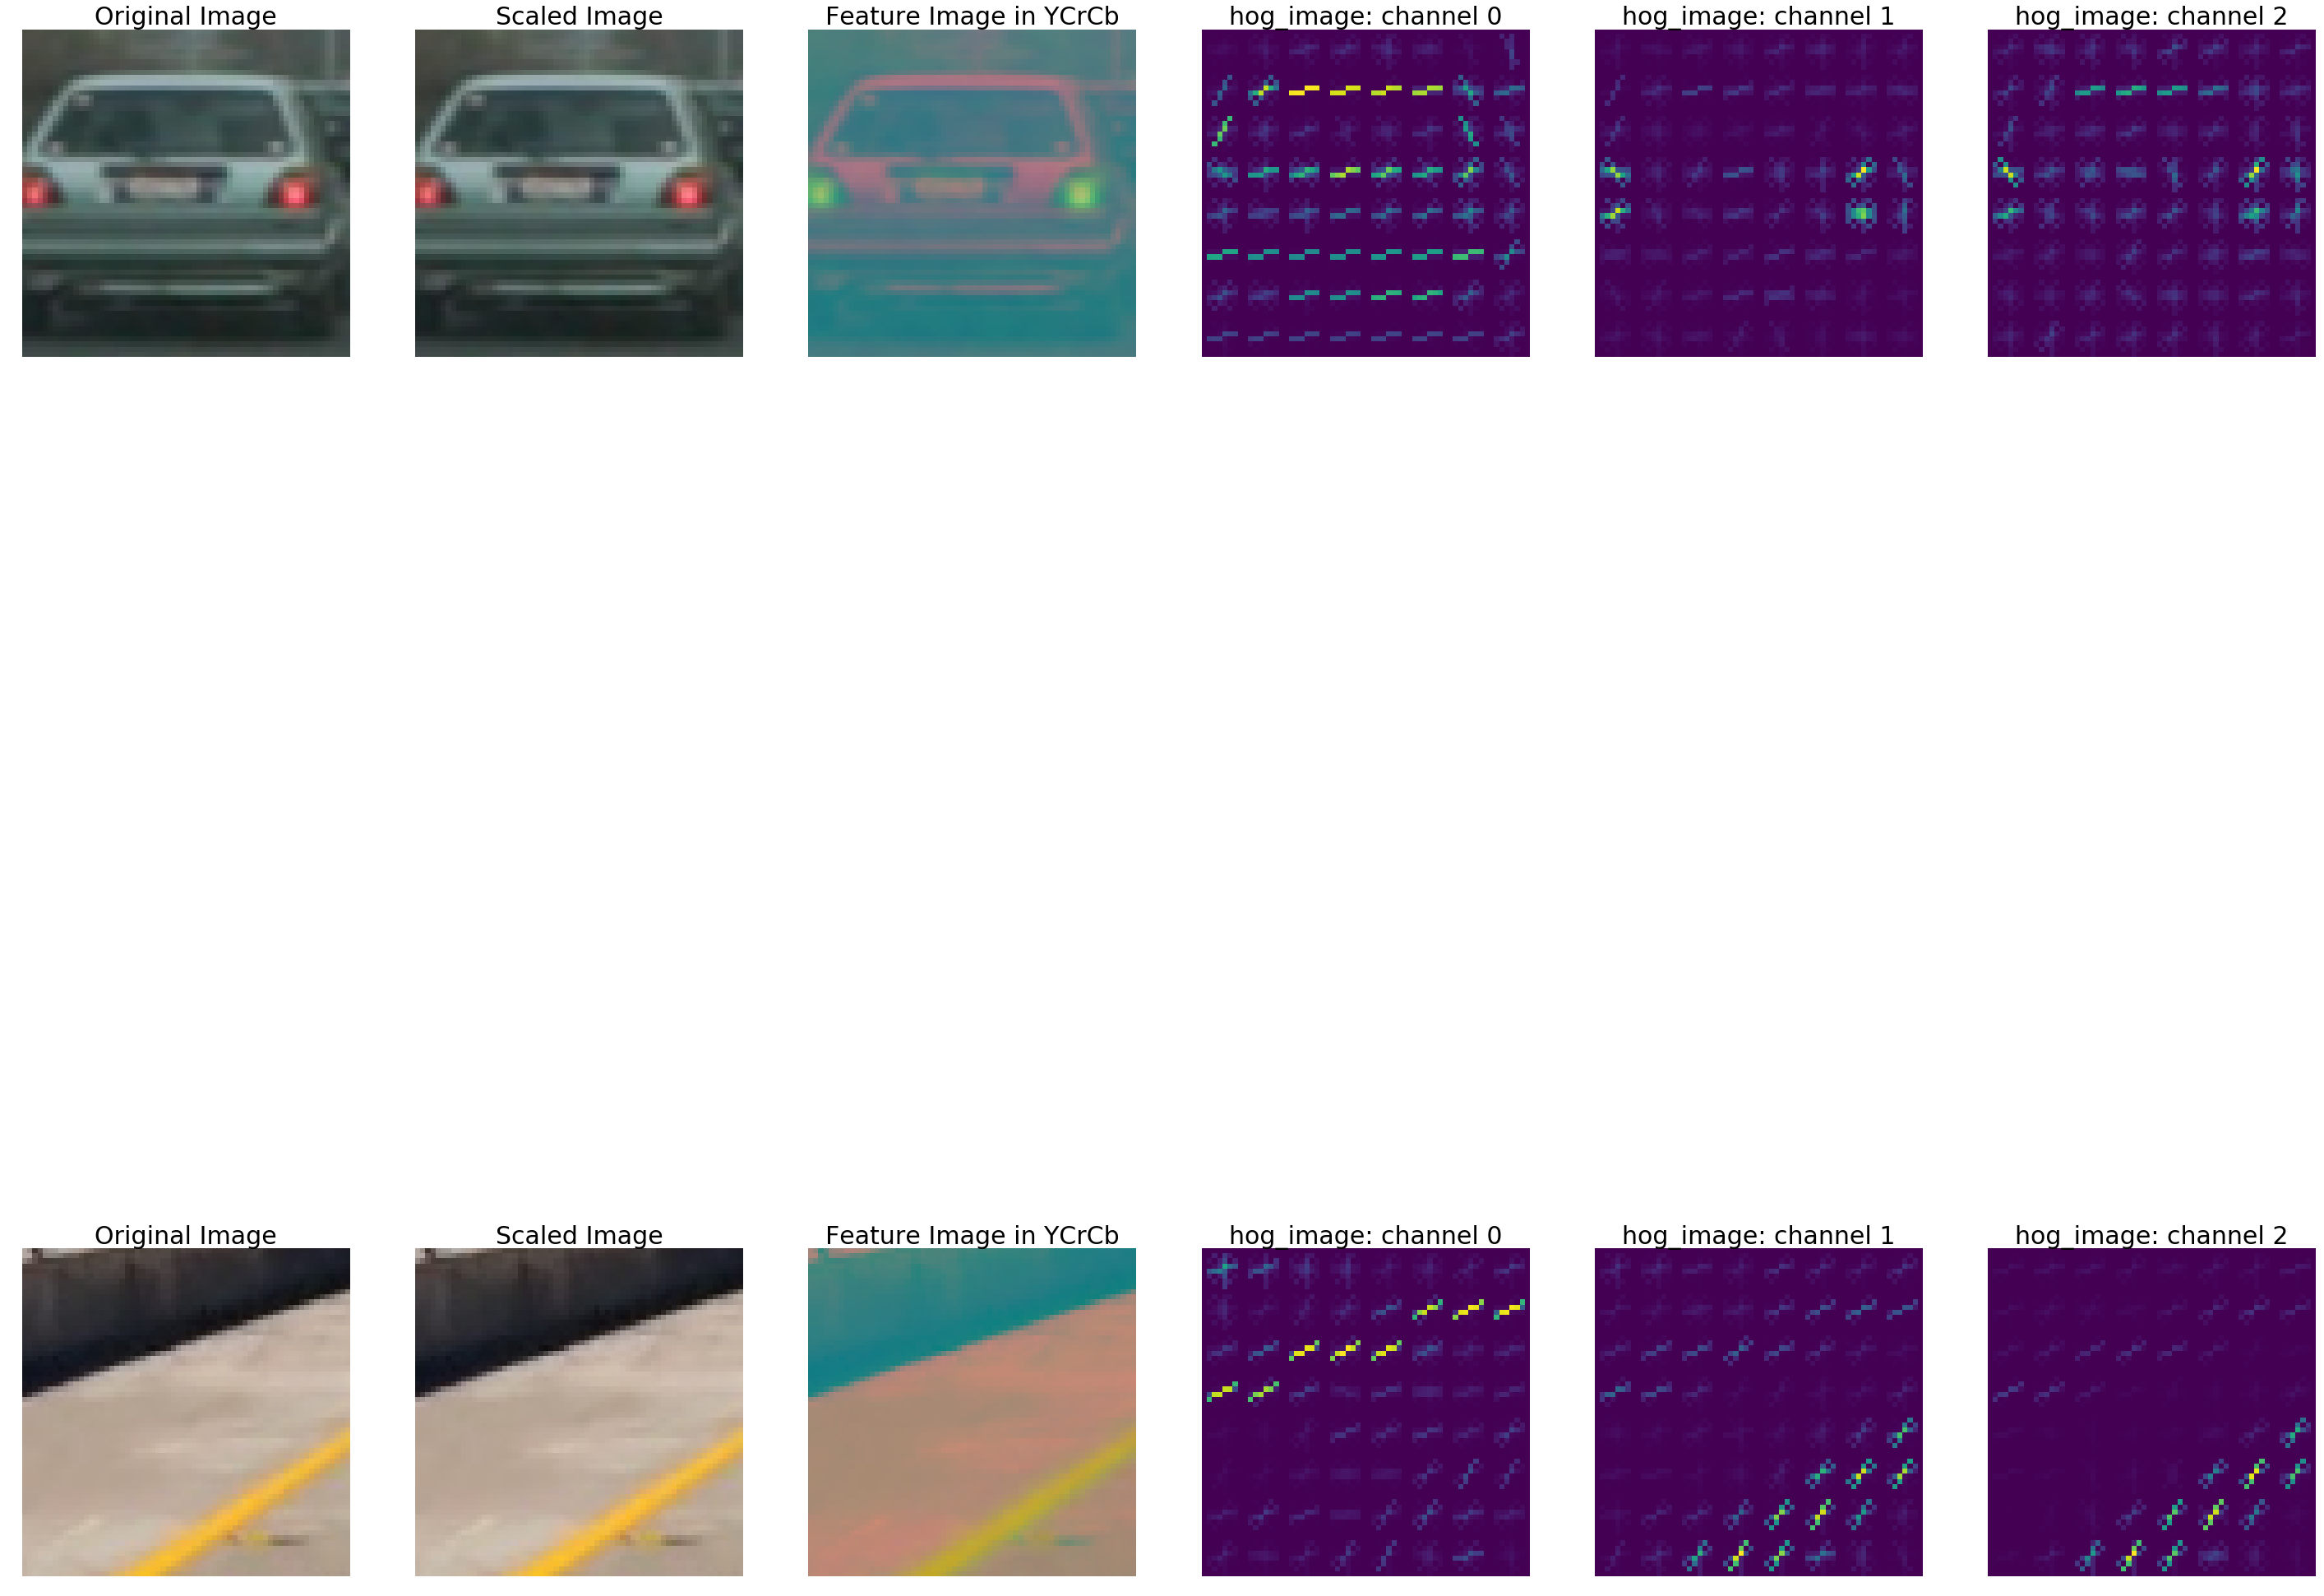

In [4]:

# generate intermediate test images for experimentation
carpath = "./output_images/example_car.png"
notcarpath = "./output_images/example_not_car.png"

test_images = [carpath, notcarpath]
# cspaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
cspaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
orient=9 
pix_per_cell=8
cell_per_block=2

fig = plt.figure()
fig.set_size_inches(50,50)
total_image_count = len(test_images)
image_count = 1

for file in test_images:
    fname = os.path.split(file)[-1]
    image = mpimg.imread(file)
    max_val = np.max(image)
    print("max_val " + str(max_val))
#     scaled_img = (image/max_val)*255
    scaled_img = (image/max_val)
    
    for color_space in cspaces:
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(scaled_img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(scaled_img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(scaled_img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(scaled_img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(scaled_img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
#         feature_image = scaled_img.astype(np.float32)
#         max_val = np.max(feature_image)
#         print("max_val " + color_space + str(max_val))
        
#         scaled_img = (feature_image/max_val)*255
#         scaled_img = feature_image
        plot_img = False
        if color_space == 'YCrCb':
            plot_img = True
            
        
        if plot_img:
            ax = fig.add_subplot(total_image_count, 6, image_count)
            ax.imshow(image)
            ax.axis('off')
            ax.set_title('Original Image', fontsize=30)
            image_count += 1
            ax = fig.add_subplot(total_image_count, 6, image_count)
            ax.imshow(scaled_img)
            ax.axis('off')
            ax.set_title('Scaled Image', fontsize=30)
            image_count += 1
            ax = fig.add_subplot(total_image_count, 6, image_count)
            ax.imshow(feature_image)
            ax.axis('off')
            ax.set_title('Feature Image in YCrCb', fontsize=30)
            image_count += 1

        for hog_channel in range(scaled_img.shape[2]):
            hog_features, hog_image = F.get_hog_features(
                feature_image[:,:,hog_channel], orient, 
                pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            cv2.imwrite('./output_images/Hog_' + str(hog_channel) + "_" + fname, hog_image)
            if plot_img:
                ax = fig.add_subplot(total_image_count, 6, image_count)
                ax.imshow(hog_image)
                ax.axis('off')
                ax.set_title('hog_image: channel ' + str(hog_channel), fontsize=30)
                image_count += 1

plt.show()
    

In [5]:
# Utility functions for feature engineering    

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 255, 0), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Draw the surrounding box
    font = cv2.FONT_HERSHEY_SIMPLEX
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates        
#         print(bbox)
        cv2.rectangle(imcopy, (bbox[0][0], bbox[0][1]), (bbox[1][0],bbox[1][1]), color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Define a single function that can extract features and make predictions
def find_cars(img, windows):
    possible_cars = []
    f = F.Features()
    # Iterate over all windows in the list
    positive_predictions = 0
    positive_predictions_above_threshold = 0
    for w in windows:
        # Extract the test window from original image
        sub_image = img[w[0][1]:w[1][1], w[0][0]:w[1][0]]
        test_img = cv2.resize(sub_image, (64, 64))
        # Extract features for that window 
        features = f.extract_features_image(test_img, color_space='YCrCb')
        # Scale extracted features to be fed to classifier
        test_features = X_scaler.transform(np.array(features).reshape(1, -1))
        # Predict using your classifier
        prediction = clf.predict(test_features)
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            # Confidence score
            confidence_score = clf.predict_proba(test_features)
#             print("confidence_score", confidence_score[0][1])
            if confidence_score[0][1] > 0.50:   # probability threshold for positive detection
                possible_cars.append(w)
                positive_predictions_above_threshold += 1
            positive_predictions += 1
    # Return windows for positive detections
    print("positive_predictions:", positive_predictions)
    print("positive_predictions_above_threshold:", positive_predictions_above_threshold)
    return possible_cars

def add_heat(heatmap, bbox_list, expand_area=25):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], (box[0][0]-expand_area):(box[1][0]+expand_area)] += 1

    # Return updated heatmap
    return heatmap # Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image
    return img

def get_labeled_bboxes(labels):
    # Iterate through all detected cars
    cars = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cars.append(bbox)
    # Return the image
    return cars

# Define a single function that can extract features and make predictions
def harden_detections(image, possible_cars):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, possible_cars)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    print("Labels:", labels[1])

    cars = get_labeled_bboxes(labels)
    
    # Merge cars    
    draw_img = draw_boxes(np.copy(image), cars)
    return draw_img

In [8]:
def process_image(img, debug=False):
    # scaled_img = img.astype(np.float32)/255
    max_val = np.max(img)
    print("max_val " + str(max_val))
    scaled_img = (img.astype(np.float32)/max_val)
    
    windows = p.getWindows(scaled_img)
    print("all:", len(windows))
    possible_cars = find_cars(scaled_img, windows)
    print("possible_cars:", len(possible_cars))
    final_img = harden_detections(img, possible_cars)
    
    if debug:
        pre_filter_img = draw_boxes(img, possible_cars)
        return final_img, pre_filter_img
    else:
        return final_img


Testing image ./test_images/test1.jpg
max_val 255
all: 567
positive_predictions: 11
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
Testing image ./test_images/test2.jpg
max_val 255
all: 567
positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Testing image ./test_images/test3.jpg
max_val 255
all: 567
positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Testing image ./test_images/test4.jpg
max_val 255
all: 567
positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
Testing image ./test_images/test5.jpg
max_val 255
all: 567
positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 2
Testing image ./test_images/test6.jpg
max_val 255
all: 567
positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2


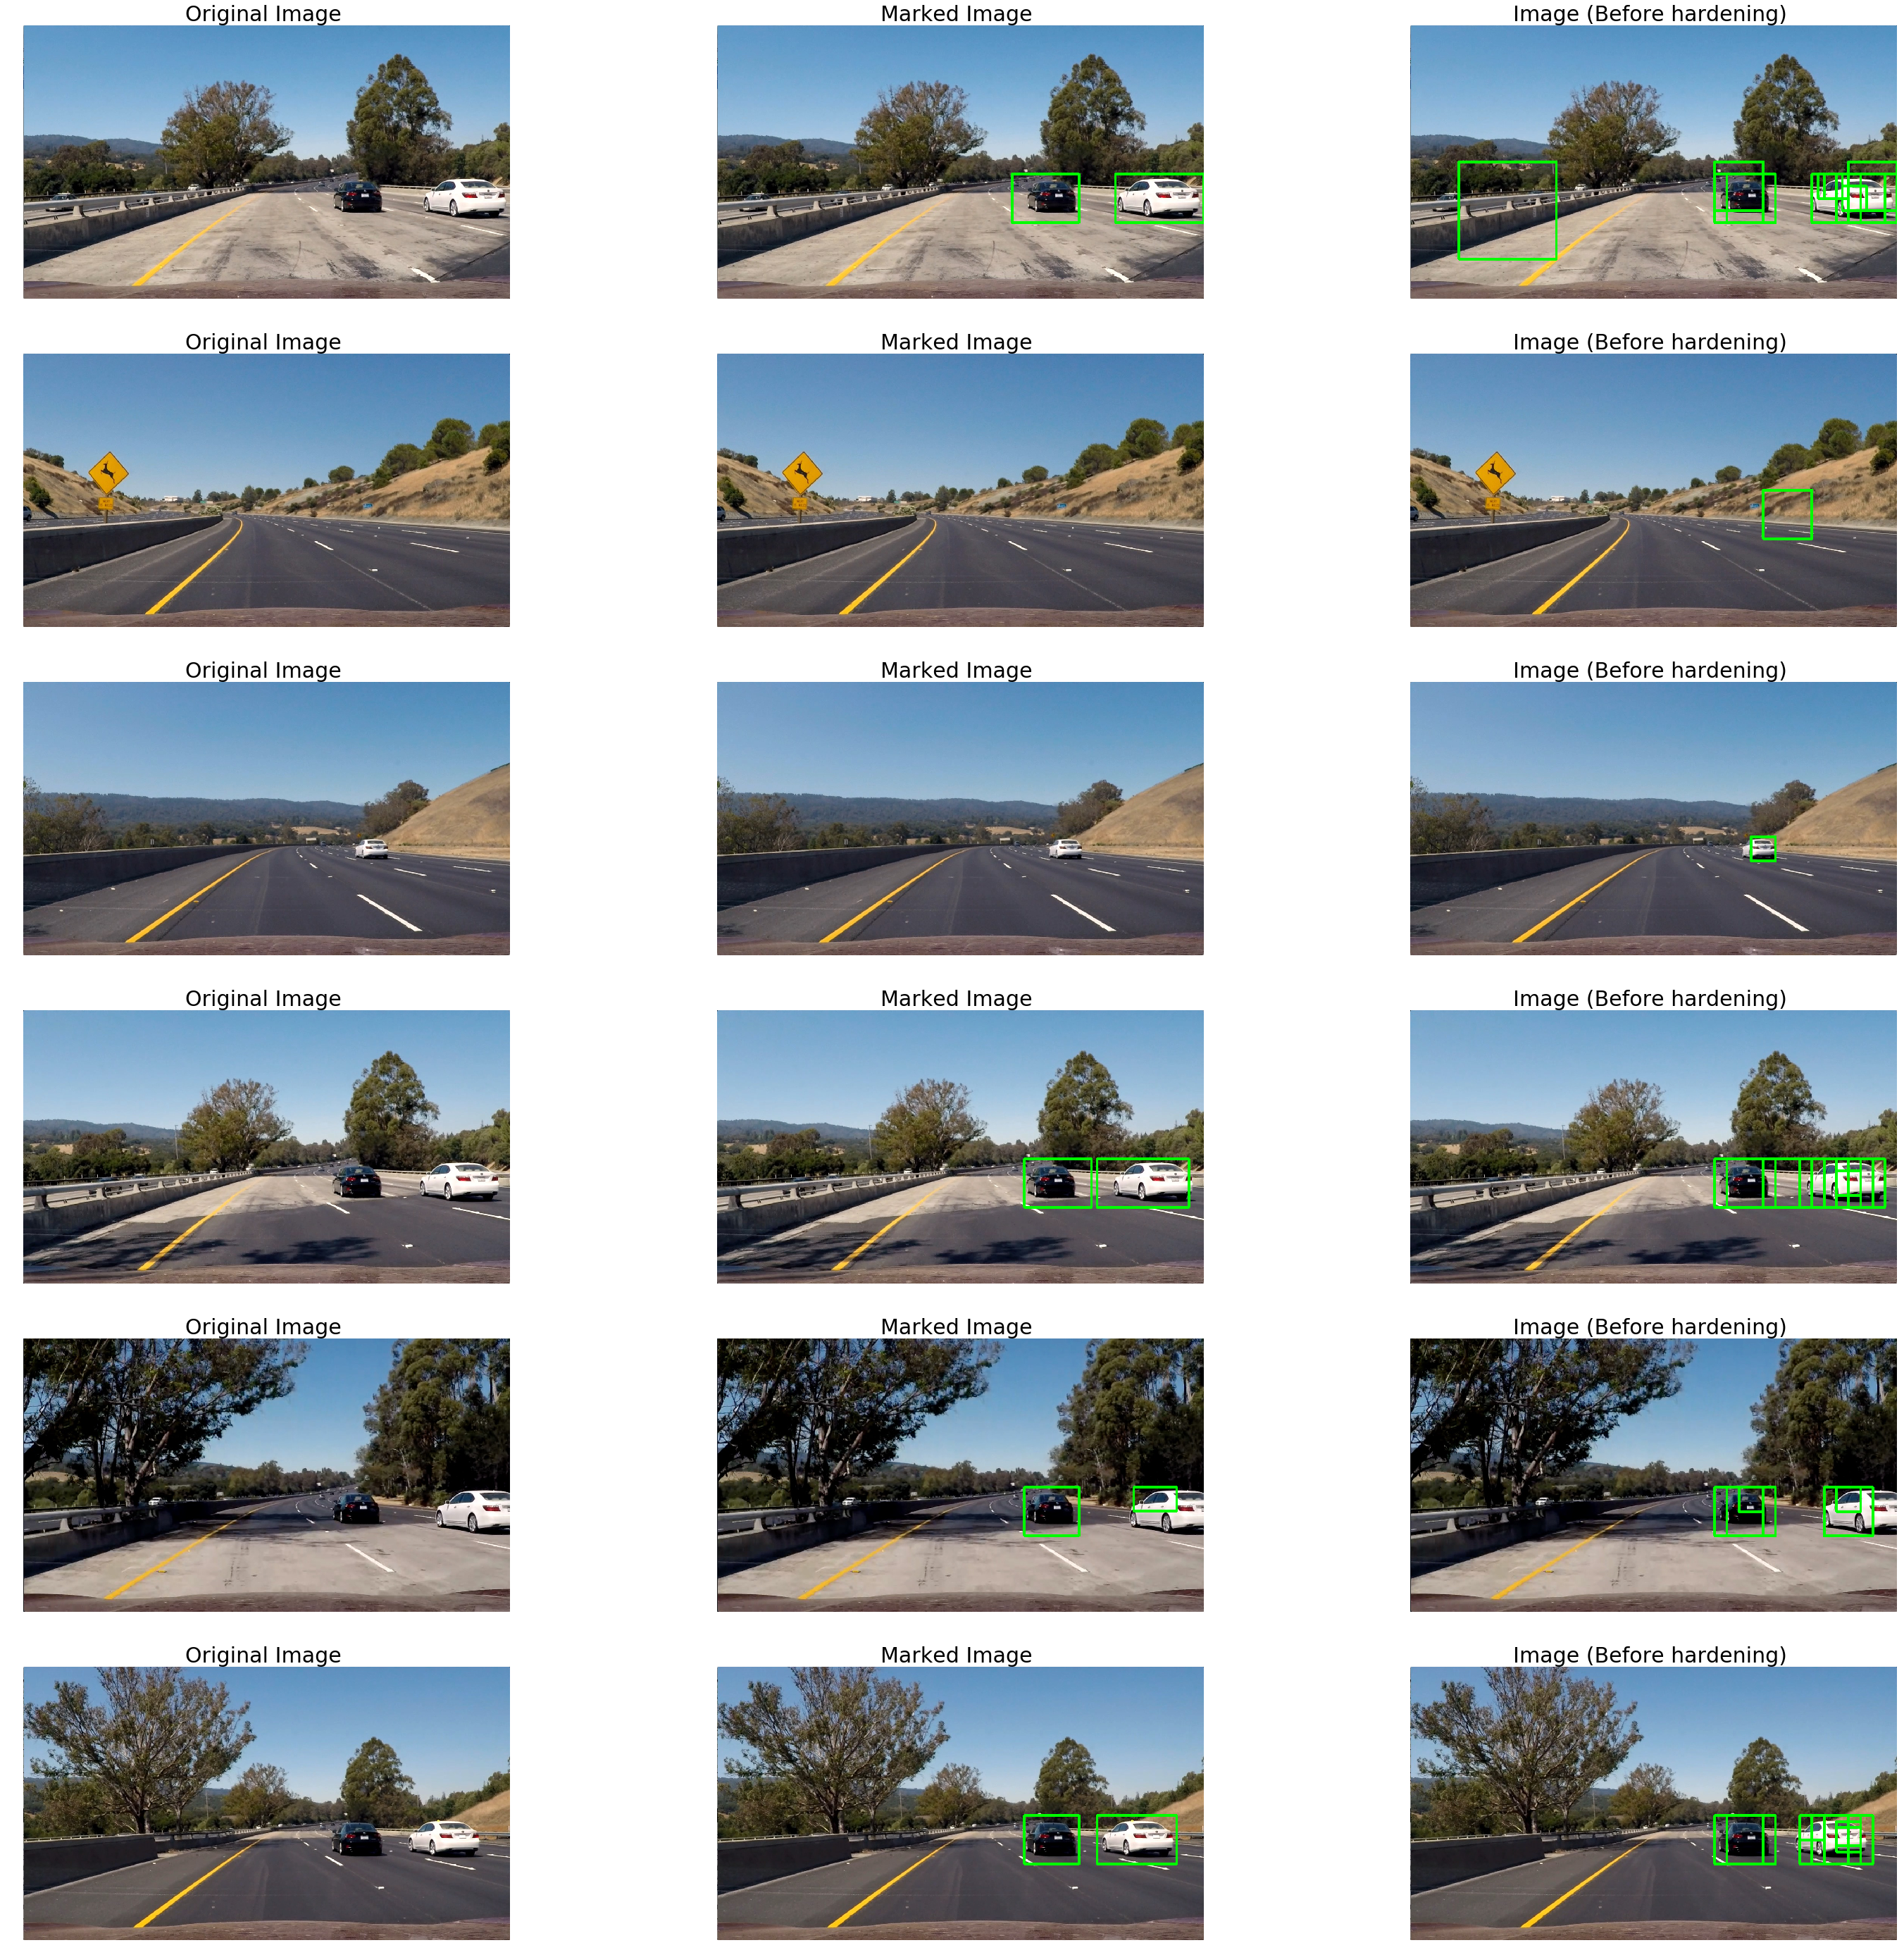

In [9]:
# Test images

image_path = "./test_images/*.jpg"
images = glob.glob(image_path)

fig = plt.figure()
fig.set_size_inches(50,50)

total_image_count = len(images)
image_count = 1

for fname in images:
    print("Testing image {}".format(fname))

    img = mpimg.imread(fname)
    marked_img, pre_filter_img = process_image(img, debug=True)

    ax = fig.add_subplot(total_image_count, 3, image_count)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('Original Image ', fontsize=30)
    image_count += 1

    ax = fig.add_subplot(total_image_count, 3, image_count)
    ax.imshow(marked_img)
    ax.axis('off')
    ax.set_title('Marked Image ', fontsize=30)
    image_count += 1

    
    ax = fig.add_subplot(total_image_count, 3, image_count)
    ax.imshow(pre_filter_img)
    ax.axis('off')
    ax.set_title('Image (Before hardening) ', fontsize=30)
    image_count += 1
    
    cv2.imwrite('./output_images/Marked_' + os.path.split(fname)[-1], marked_img)
    cv2.imwrite('./output_images/pre_filter_img_' + os.path.split(fname)[-1], pre_filter_img)

plt.show()


In [9]:
# Test Video
# clip1 = VideoFileClip("./project_video.mp4")
# clip = clip1.subclip(38, 43)
clip = VideoFileClip("./project_video.mp4")
output_video = "./project_video_marked.mp4"
output_clip = clip.fl_image(process_image)
output_clip.write_videofile(output_video, audio=False)


all: 567
positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
[MoviePy] >>>> Building video ./project_video_marked.mp4
[MoviePy] Writing video ./project_video_marked.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

all: 567


  0%|          | 1/1261 [00:01<41:33,  1.98s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  0%|          | 2/1261 [00:04<42:42,  2.04s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  0%|          | 3/1261 [00:06<43:37,  2.08s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  0%|          | 4/1261 [00:08<46:48,  2.23s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  0%|          | 5/1261 [00:11<46:27,  2.22s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  0%|          | 6/1261 [00:13<45:24,  2.17s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  1%|          | 7/1261 [00:15<44:26,  2.13s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  1%|          | 8/1261 [00:17<43:51,  2.10s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  1%|          | 9/1261 [00:19<44:35,  2.14s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  1%|          | 10/1261 [00:21<44:09,  2.12s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  1%|          | 11/1261 [00:23<43:13,  2.07s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  1%|          | 12/1261 [00:25<42:23,  2.04s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  1%|          | 13/1261 [00:27<41:47,  2.01s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  1%|          | 14/1261 [00:29<41:24,  1.99s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  1%|          | 15/1261 [00:31<41:37,  2.00s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  1%|▏         | 16/1261 [00:33<42:16,  2.04s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  1%|▏         | 17/1261 [00:35<41:19,  1.99s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  1%|▏         | 18/1261 [00:37<41:14,  1.99s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  2%|▏         | 19/1261 [00:39<41:05,  1.99s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  2%|▏         | 20/1261 [00:41<40:37,  1.96s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  2%|▏         | 21/1261 [00:43<40:18,  1.95s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  2%|▏         | 22/1261 [00:45<40:10,  1.95s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  2%|▏         | 23/1261 [00:47<40:04,  1.94s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  2%|▏         | 24/1261 [00:48<39:57,  1.94s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  2%|▏         | 25/1261 [00:50<39:42,  1.93s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  2%|▏         | 26/1261 [00:52<39:17,  1.91s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  2%|▏         | 27/1261 [00:54<39:00,  1.90s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  2%|▏         | 28/1261 [00:56<39:07,  1.90s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  2%|▏         | 29/1261 [00:58<39:17,  1.91s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  2%|▏         | 30/1261 [01:00<39:14,  1.91s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  2%|▏         | 31/1261 [01:02<38:48,  1.89s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  3%|▎         | 32/1261 [01:04<38:37,  1.89s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  3%|▎         | 33/1261 [01:05<38:29,  1.88s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  3%|▎         | 34/1261 [01:07<38:39,  1.89s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  3%|▎         | 35/1261 [01:09<38:59,  1.91s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  3%|▎         | 36/1261 [01:11<38:54,  1.91s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  3%|▎         | 37/1261 [01:13<38:09,  1.87s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  3%|▎         | 38/1261 [01:15<38:01,  1.87s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  3%|▎         | 39/1261 [01:17<37:44,  1.85s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  3%|▎         | 40/1261 [01:19<37:38,  1.85s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  3%|▎         | 41/1261 [01:20<37:37,  1.85s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  3%|▎         | 42/1261 [01:22<38:07,  1.88s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  3%|▎         | 43/1261 [01:24<37:41,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  3%|▎         | 44/1261 [01:26<37:40,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  4%|▎         | 45/1261 [01:28<37:37,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  4%|▎         | 46/1261 [01:30<37:34,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  4%|▎         | 47/1261 [01:32<37:47,  1.87s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  4%|▍         | 48/1261 [01:33<37:37,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  4%|▍         | 49/1261 [01:35<37:32,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  4%|▍         | 50/1261 [01:37<37:32,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  4%|▍         | 51/1261 [01:39<37:31,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  4%|▍         | 52/1261 [01:41<37:30,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  4%|▍         | 53/1261 [01:43<37:40,  1.87s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  4%|▍         | 54/1261 [01:45<37:16,  1.85s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  4%|▍         | 55/1261 [01:46<37:08,  1.85s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  4%|▍         | 56/1261 [01:48<36:58,  1.84s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  5%|▍         | 57/1261 [01:50<36:52,  1.84s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  5%|▍         | 58/1261 [01:52<36:54,  1.84s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  5%|▍         | 59/1261 [01:54<37:29,  1.87s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  5%|▍         | 60/1261 [01:56<37:15,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  5%|▍         | 61/1261 [01:58<37:17,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  5%|▍         | 62/1261 [01:59<36:56,  1.85s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  5%|▍         | 63/1261 [02:01<36:44,  1.84s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  5%|▌         | 64/1261 [02:03<36:43,  1.84s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  5%|▌         | 65/1261 [02:05<37:04,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  5%|▌         | 66/1261 [02:07<36:57,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  5%|▌         | 67/1261 [02:09<37:09,  1.87s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  5%|▌         | 68/1261 [02:11<37:03,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  5%|▌         | 69/1261 [02:12<36:51,  1.85s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  6%|▌         | 70/1261 [02:14<37:17,  1.88s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  6%|▌         | 71/1261 [02:16<37:07,  1.87s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  6%|▌         | 72/1261 [02:18<36:43,  1.85s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  6%|▌         | 73/1261 [02:20<36:23,  1.84s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  6%|▌         | 74/1261 [02:22<36:17,  1.83s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  6%|▌         | 75/1261 [02:23<36:15,  1.83s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  6%|▌         | 76/1261 [02:25<36:28,  1.85s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  6%|▌         | 77/1261 [02:27<36:29,  1.85s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  6%|▌         | 78/1261 [02:29<36:19,  1.84s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  6%|▋         | 79/1261 [02:31<36:09,  1.84s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  6%|▋         | 80/1261 [02:33<36:27,  1.85s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  6%|▋         | 81/1261 [02:35<36:34,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  7%|▋         | 82/1261 [02:36<36:34,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  7%|▋         | 83/1261 [02:38<36:28,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  7%|▋         | 84/1261 [02:40<36:23,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  7%|▋         | 85/1261 [02:42<36:15,  1.85s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  7%|▋         | 86/1261 [02:44<37:06,  1.90s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  7%|▋         | 87/1261 [02:46<37:40,  1.93s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  7%|▋         | 88/1261 [02:48<37:24,  1.91s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  7%|▋         | 89/1261 [02:50<37:30,  1.92s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  7%|▋         | 90/1261 [02:52<37:24,  1.92s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  7%|▋         | 91/1261 [02:54<36:45,  1.89s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  7%|▋         | 92/1261 [02:55<36:06,  1.85s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  7%|▋         | 93/1261 [02:57<36:09,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  7%|▋         | 94/1261 [02:59<35:53,  1.84s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  8%|▊         | 95/1261 [03:01<35:48,  1.84s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  8%|▊         | 96/1261 [03:03<35:57,  1.85s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  8%|▊         | 97/1261 [03:05<35:43,  1.84s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  8%|▊         | 98/1261 [03:06<36:11,  1.87s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  8%|▊         | 99/1261 [03:08<36:03,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  8%|▊         | 100/1261 [03:10<36:27,  1.88s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  8%|▊         | 101/1261 [03:12<36:37,  1.89s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  8%|▊         | 102/1261 [03:14<36:20,  1.88s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  8%|▊         | 103/1261 [03:16<36:07,  1.87s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  8%|▊         | 104/1261 [03:18<36:03,  1.87s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  8%|▊         | 105/1261 [03:20<36:08,  1.88s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  8%|▊         | 106/1261 [03:21<35:44,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  8%|▊         | 107/1261 [03:23<35:21,  1.84s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  9%|▊         | 108/1261 [03:25<35:11,  1.83s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  9%|▊         | 109/1261 [03:27<35:10,  1.83s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  9%|▊         | 110/1261 [03:29<35:07,  1.83s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  9%|▉         | 111/1261 [03:31<35:20,  1.84s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  9%|▉         | 112/1261 [03:33<37:35,  1.96s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  9%|▉         | 113/1261 [03:35<36:52,  1.93s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  9%|▉         | 114/1261 [03:37<36:28,  1.91s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  9%|▉         | 115/1261 [03:38<36:08,  1.89s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  9%|▉         | 116/1261 [03:40<36:11,  1.90s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  9%|▉         | 117/1261 [03:42<35:54,  1.88s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  9%|▉         | 118/1261 [03:44<36:00,  1.89s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


  9%|▉         | 119/1261 [03:46<35:51,  1.88s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 10%|▉         | 120/1261 [03:48<35:33,  1.87s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 10%|▉         | 121/1261 [03:50<35:26,  1.87s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 10%|▉         | 122/1261 [03:51<35:02,  1.85s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 10%|▉         | 123/1261 [03:53<35:14,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 10%|▉         | 124/1261 [03:55<35:09,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 10%|▉         | 125/1261 [03:57<34:57,  1.85s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 10%|▉         | 126/1261 [03:59<35:04,  1.85s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 10%|█         | 127/1261 [04:01<35:05,  1.86s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 10%|█         | 128/1261 [04:03<35:00,  1.85s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 10%|█         | 129/1261 [04:04<34:46,  1.84s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 10%|█         | 130/1261 [04:06<34:32,  1.83s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 10%|█         | 131/1261 [04:08<34:38,  1.84s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 10%|█         | 132/1261 [04:10<34:37,  1.84s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
all: 567


 11%|█         | 133/1261 [04:12<34:35,  1.84s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 11%|█         | 134/1261 [04:14<34:49,  1.85s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 11%|█         | 135/1261 [04:15<34:54,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 11%|█         | 136/1261 [04:17<34:49,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 11%|█         | 137/1261 [04:19<34:38,  1.85s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 11%|█         | 138/1261 [04:21<34:55,  1.87s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 11%|█         | 139/1261 [04:23<34:51,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 11%|█         | 140/1261 [04:25<34:39,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 11%|█         | 141/1261 [04:27<34:19,  1.84s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 11%|█▏        | 142/1261 [04:28<34:09,  1.83s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 11%|█▏        | 143/1261 [04:30<34:09,  1.83s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 11%|█▏        | 144/1261 [04:32<33:58,  1.82s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 11%|█▏        | 145/1261 [04:34<33:49,  1.82s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 12%|█▏        | 146/1261 [04:36<33:44,  1.82s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 12%|█▏        | 147/1261 [04:37<34:00,  1.83s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 12%|█▏        | 148/1261 [04:39<33:58,  1.83s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 12%|█▏        | 149/1261 [04:41<33:53,  1.83s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 12%|█▏        | 150/1261 [04:43<33:59,  1.84s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 12%|█▏        | 151/1261 [04:45<33:49,  1.83s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 12%|█▏        | 152/1261 [04:47<33:44,  1.83s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 12%|█▏        | 153/1261 [04:48<33:45,  1.83s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 12%|█▏        | 154/1261 [04:50<33:40,  1.82s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 12%|█▏        | 155/1261 [04:52<33:37,  1.82s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 12%|█▏        | 156/1261 [04:54<33:39,  1.83s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 12%|█▏        | 157/1261 [04:56<33:43,  1.83s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 13%|█▎        | 158/1261 [04:58<33:58,  1.85s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 13%|█▎        | 159/1261 [04:59<33:35,  1.83s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 13%|█▎        | 160/1261 [05:01<34:08,  1.86s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 13%|█▎        | 161/1261 [05:03<34:02,  1.86s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 13%|█▎        | 162/1261 [05:05<34:11,  1.87s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 13%|█▎        | 163/1261 [05:07<33:58,  1.86s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 13%|█▎        | 164/1261 [05:09<33:52,  1.85s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 13%|█▎        | 165/1261 [05:11<33:43,  1.85s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 13%|█▎        | 166/1261 [05:13<33:54,  1.86s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 13%|█▎        | 167/1261 [05:14<33:48,  1.85s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 13%|█▎        | 168/1261 [05:16<34:06,  1.87s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 13%|█▎        | 169/1261 [05:18<33:48,  1.86s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 13%|█▎        | 170/1261 [05:20<33:30,  1.84s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 14%|█▎        | 171/1261 [05:22<33:20,  1.84s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 14%|█▎        | 172/1261 [05:24<33:20,  1.84s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 14%|█▎        | 173/1261 [05:25<33:21,  1.84s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 14%|█▍        | 174/1261 [05:27<33:22,  1.84s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 14%|█▍        | 175/1261 [05:29<33:43,  1.86s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 14%|█▍        | 176/1261 [05:31<33:24,  1.85s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 14%|█▍        | 177/1261 [05:33<33:10,  1.84s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 14%|█▍        | 178/1261 [05:35<33:02,  1.83s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 14%|█▍        | 179/1261 [05:36<33:10,  1.84s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 14%|█▍        | 180/1261 [05:38<33:19,  1.85s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 14%|█▍        | 181/1261 [05:40<32:57,  1.83s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 14%|█▍        | 182/1261 [05:42<32:51,  1.83s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 15%|█▍        | 183/1261 [05:44<32:42,  1.82s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 15%|█▍        | 184/1261 [05:46<32:38,  1.82s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 15%|█▍        | 185/1261 [05:47<32:24,  1.81s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 15%|█▍        | 186/1261 [05:49<32:26,  1.81s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 15%|█▍        | 187/1261 [05:51<32:49,  1.83s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 15%|█▍        | 188/1261 [05:53<32:46,  1.83s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 15%|█▍        | 189/1261 [05:55<32:43,  1.83s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 15%|█▌        | 190/1261 [05:57<32:46,  1.84s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 15%|█▌        | 191/1261 [05:58<32:52,  1.84s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 15%|█▌        | 192/1261 [06:00<33:10,  1.86s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 15%|█▌        | 193/1261 [06:02<32:47,  1.84s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 15%|█▌        | 194/1261 [06:04<33:08,  1.86s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 15%|█▌        | 195/1261 [06:06<33:46,  1.90s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 16%|█▌        | 196/1261 [06:08<33:42,  1.90s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 16%|█▌        | 197/1261 [06:10<33:27,  1.89s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 16%|█▌        | 198/1261 [06:12<33:10,  1.87s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 16%|█▌        | 199/1261 [06:13<32:50,  1.86s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 16%|█▌        | 200/1261 [06:15<32:41,  1.85s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 16%|█▌        | 201/1261 [06:17<32:30,  1.84s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 16%|█▌        | 202/1261 [06:19<32:26,  1.84s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 16%|█▌        | 203/1261 [06:21<32:19,  1.83s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 16%|█▌        | 204/1261 [06:23<32:42,  1.86s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 16%|█▋        | 205/1261 [06:24<32:35,  1.85s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 16%|█▋        | 206/1261 [06:26<32:21,  1.84s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 16%|█▋        | 207/1261 [06:28<32:20,  1.84s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 16%|█▋        | 208/1261 [06:30<32:13,  1.84s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 17%|█▋        | 209/1261 [06:32<32:10,  1.83s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 17%|█▋        | 210/1261 [06:34<31:58,  1.83s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 17%|█▋        | 211/1261 [06:35<31:49,  1.82s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 17%|█▋        | 212/1261 [06:37<32:15,  1.84s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 17%|█▋        | 213/1261 [06:39<32:10,  1.84s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 17%|█▋        | 214/1261 [06:41<32:11,  1.84s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 17%|█▋        | 215/1261 [06:43<32:10,  1.85s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 17%|█▋        | 216/1261 [06:45<32:22,  1.86s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 17%|█▋        | 217/1261 [06:47<32:13,  1.85s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 17%|█▋        | 218/1261 [06:48<32:05,  1.85s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 17%|█▋        | 219/1261 [06:50<32:01,  1.84s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 17%|█▋        | 220/1261 [06:52<32:05,  1.85s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 18%|█▊        | 221/1261 [06:54<31:56,  1.84s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 18%|█▊        | 222/1261 [06:56<31:49,  1.84s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 18%|█▊        | 223/1261 [06:58<31:43,  1.83s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 18%|█▊        | 224/1261 [06:59<32:03,  1.86s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 18%|█▊        | 225/1261 [07:01<31:57,  1.85s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 18%|█▊        | 226/1261 [07:03<31:53,  1.85s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 18%|█▊        | 227/1261 [07:05<32:19,  1.88s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 18%|█▊        | 228/1261 [07:07<32:05,  1.86s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 18%|█▊        | 229/1261 [07:09<32:16,  1.88s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 18%|█▊        | 230/1261 [07:11<32:03,  1.87s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 18%|█▊        | 231/1261 [07:13<32:00,  1.87s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 18%|█▊        | 232/1261 [07:14<31:56,  1.86s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 18%|█▊        | 233/1261 [07:16<32:16,  1.88s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 19%|█▊        | 234/1261 [07:18<31:59,  1.87s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 19%|█▊        | 235/1261 [07:20<32:04,  1.88s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 19%|█▊        | 236/1261 [07:22<31:50,  1.86s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 19%|█▉        | 237/1261 [07:24<31:46,  1.86s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 19%|█▉        | 238/1261 [07:26<31:44,  1.86s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 19%|█▉        | 239/1261 [07:27<31:39,  1.86s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 19%|█▉        | 240/1261 [07:29<31:30,  1.85s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 19%|█▉        | 241/1261 [07:31<31:18,  1.84s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 19%|█▉        | 242/1261 [07:33<31:06,  1.83s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 19%|█▉        | 243/1261 [07:35<31:10,  1.84s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 19%|█▉        | 244/1261 [07:37<31:00,  1.83s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 19%|█▉        | 245/1261 [07:38<30:55,  1.83s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 20%|█▉        | 246/1261 [07:40<30:56,  1.83s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 20%|█▉        | 247/1261 [07:42<30:57,  1.83s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 20%|█▉        | 248/1261 [07:44<31:06,  1.84s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 20%|█▉        | 249/1261 [07:46<31:07,  1.85s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 20%|█▉        | 250/1261 [07:48<31:07,  1.85s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 20%|█▉        | 251/1261 [07:50<31:30,  1.87s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 20%|█▉        | 252/1261 [07:51<31:21,  1.86s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 20%|██        | 253/1261 [07:53<31:13,  1.86s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 20%|██        | 254/1261 [07:55<31:08,  1.86s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 20%|██        | 255/1261 [07:57<31:12,  1.86s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 20%|██        | 256/1261 [07:59<31:09,  1.86s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 20%|██        | 257/1261 [08:01<31:14,  1.87s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 20%|██        | 258/1261 [08:03<31:40,  1.90s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 21%|██        | 259/1261 [08:05<31:33,  1.89s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 21%|██        | 260/1261 [08:06<31:21,  1.88s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 21%|██        | 261/1261 [08:08<31:00,  1.86s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 21%|██        | 262/1261 [08:10<31:10,  1.87s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 21%|██        | 263/1261 [08:12<31:06,  1.87s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 21%|██        | 264/1261 [08:14<31:03,  1.87s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 21%|██        | 265/1261 [08:16<30:50,  1.86s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 21%|██        | 266/1261 [08:18<30:55,  1.86s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 21%|██        | 267/1261 [08:19<30:50,  1.86s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 21%|██▏       | 268/1261 [08:21<31:20,  1.89s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 21%|██▏       | 269/1261 [08:23<31:27,  1.90s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 21%|██▏       | 270/1261 [08:25<31:31,  1.91s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 21%|██▏       | 271/1261 [08:27<31:14,  1.89s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 22%|██▏       | 272/1261 [08:29<30:55,  1.88s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 22%|██▏       | 273/1261 [08:31<30:40,  1.86s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 22%|██▏       | 274/1261 [08:33<30:43,  1.87s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 22%|██▏       | 275/1261 [08:35<30:35,  1.86s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 22%|██▏       | 276/1261 [08:36<30:31,  1.86s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 22%|██▏       | 277/1261 [08:38<30:31,  1.86s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 22%|██▏       | 278/1261 [08:40<30:40,  1.87s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 22%|██▏       | 279/1261 [08:42<30:46,  1.88s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 22%|██▏       | 280/1261 [08:44<30:31,  1.87s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 22%|██▏       | 281/1261 [08:46<30:39,  1.88s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 22%|██▏       | 282/1261 [08:48<30:34,  1.87s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 22%|██▏       | 283/1261 [08:50<30:31,  1.87s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 23%|██▎       | 284/1261 [08:51<30:33,  1.88s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 23%|██▎       | 285/1261 [08:53<30:30,  1.88s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
all: 567


 23%|██▎       | 286/1261 [08:55<30:27,  1.87s/it]

positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
all: 567


 23%|██▎       | 287/1261 [08:57<30:11,  1.86s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 23%|██▎       | 288/1261 [08:59<30:11,  1.86s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 23%|██▎       | 289/1261 [09:01<30:14,  1.87s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 23%|██▎       | 290/1261 [09:03<30:30,  1.88s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 23%|██▎       | 291/1261 [09:05<30:24,  1.88s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 23%|██▎       | 292/1261 [09:06<30:30,  1.89s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 23%|██▎       | 293/1261 [09:08<30:40,  1.90s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 23%|██▎       | 294/1261 [09:10<30:28,  1.89s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 23%|██▎       | 295/1261 [09:12<30:17,  1.88s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 23%|██▎       | 296/1261 [09:14<30:12,  1.88s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 24%|██▎       | 297/1261 [09:16<29:56,  1.86s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 24%|██▎       | 298/1261 [09:18<29:50,  1.86s/it]

positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
all: 567


 24%|██▎       | 299/1261 [09:19<29:49,  1.86s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
all: 567


 24%|██▍       | 300/1261 [09:21<29:58,  1.87s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 24%|██▍       | 301/1261 [09:23<29:51,  1.87s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 24%|██▍       | 302/1261 [09:25<29:51,  1.87s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 24%|██▍       | 303/1261 [09:27<29:46,  1.86s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 24%|██▍       | 304/1261 [09:29<29:49,  1.87s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 24%|██▍       | 305/1261 [09:31<29:50,  1.87s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 24%|██▍       | 306/1261 [09:33<29:38,  1.86s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 24%|██▍       | 307/1261 [09:34<29:30,  1.86s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 24%|██▍       | 308/1261 [09:36<29:50,  1.88s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 25%|██▍       | 309/1261 [09:38<29:51,  1.88s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 25%|██▍       | 310/1261 [09:40<29:47,  1.88s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 25%|██▍       | 311/1261 [09:42<29:37,  1.87s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 25%|██▍       | 312/1261 [09:44<29:29,  1.86s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 25%|██▍       | 313/1261 [09:46<29:18,  1.85s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 25%|██▍       | 314/1261 [09:47<29:00,  1.84s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 25%|██▍       | 315/1261 [09:49<29:00,  1.84s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 25%|██▌       | 316/1261 [09:51<29:00,  1.84s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 25%|██▌       | 317/1261 [09:53<29:23,  1.87s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 25%|██▌       | 318/1261 [09:55<29:17,  1.86s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 25%|██▌       | 319/1261 [09:57<29:15,  1.86s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 25%|██▌       | 320/1261 [09:59<29:04,  1.85s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 25%|██▌       | 321/1261 [10:00<29:01,  1.85s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 26%|██▌       | 322/1261 [10:02<29:04,  1.86s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 26%|██▌       | 323/1261 [10:04<29:19,  1.88s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 26%|██▌       | 324/1261 [10:06<29:06,  1.86s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 26%|██▌       | 325/1261 [10:08<29:04,  1.86s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 26%|██▌       | 326/1261 [10:10<29:11,  1.87s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 26%|██▌       | 327/1261 [10:12<29:12,  1.88s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 26%|██▌       | 328/1261 [10:14<29:05,  1.87s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 26%|██▌       | 329/1261 [10:16<29:23,  1.89s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 26%|██▌       | 330/1261 [10:17<29:38,  1.91s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 26%|██▌       | 331/1261 [10:19<29:19,  1.89s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 26%|██▋       | 332/1261 [10:21<29:11,  1.89s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 26%|██▋       | 333/1261 [10:23<29:10,  1.89s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 26%|██▋       | 334/1261 [10:25<29:29,  1.91s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 27%|██▋       | 335/1261 [10:27<29:07,  1.89s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 27%|██▋       | 336/1261 [10:29<28:52,  1.87s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 27%|██▋       | 337/1261 [10:31<28:41,  1.86s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 27%|██▋       | 338/1261 [10:32<28:42,  1.87s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 27%|██▋       | 339/1261 [10:34<28:47,  1.87s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 27%|██▋       | 340/1261 [10:36<29:22,  1.91s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 27%|██▋       | 341/1261 [10:38<29:03,  1.89s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 27%|██▋       | 342/1261 [10:40<28:39,  1.87s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 27%|██▋       | 343/1261 [10:42<28:31,  1.86s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 27%|██▋       | 344/1261 [10:44<28:27,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 27%|██▋       | 345/1261 [10:46<28:17,  1.85s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 27%|██▋       | 346/1261 [10:47<28:25,  1.86s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 28%|██▊       | 347/1261 [10:49<28:22,  1.86s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
all: 567


 28%|██▊       | 348/1261 [10:51<28:04,  1.85s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 28%|██▊       | 349/1261 [10:53<28:04,  1.85s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 28%|██▊       | 350/1261 [10:55<28:07,  1.85s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 28%|██▊       | 351/1261 [10:57<28:05,  1.85s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 28%|██▊       | 352/1261 [10:59<28:05,  1.85s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 28%|██▊       | 353/1261 [11:00<28:00,  1.85s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 28%|██▊       | 354/1261 [11:02<27:57,  1.85s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 28%|██▊       | 355/1261 [11:04<28:09,  1.86s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 28%|██▊       | 356/1261 [11:06<28:15,  1.87s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 28%|██▊       | 357/1261 [11:08<28:00,  1.86s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 28%|██▊       | 358/1261 [11:10<28:13,  1.88s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 28%|██▊       | 359/1261 [11:12<28:20,  1.89s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 29%|██▊       | 360/1261 [11:14<28:09,  1.88s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 29%|██▊       | 361/1261 [11:15<27:57,  1.86s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 29%|██▊       | 362/1261 [11:17<27:46,  1.85s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 29%|██▉       | 363/1261 [11:19<27:40,  1.85s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 29%|██▉       | 364/1261 [11:21<27:50,  1.86s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 29%|██▉       | 365/1261 [11:23<27:36,  1.85s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 29%|██▉       | 366/1261 [11:25<27:30,  1.84s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 29%|██▉       | 367/1261 [11:26<27:25,  1.84s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 29%|██▉       | 368/1261 [11:28<27:50,  1.87s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 29%|██▉       | 369/1261 [11:30<28:09,  1.89s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 29%|██▉       | 370/1261 [11:32<27:59,  1.88s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 29%|██▉       | 371/1261 [11:34<27:44,  1.87s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 30%|██▉       | 372/1261 [11:36<27:37,  1.86s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 30%|██▉       | 373/1261 [11:38<27:33,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 30%|██▉       | 374/1261 [11:40<27:26,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 30%|██▉       | 375/1261 [11:41<27:15,  1.85s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 30%|██▉       | 376/1261 [11:43<27:12,  1.84s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 30%|██▉       | 377/1261 [11:45<27:22,  1.86s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 30%|██▉       | 378/1261 [11:47<27:20,  1.86s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 30%|███       | 379/1261 [11:49<27:07,  1.85s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 30%|███       | 380/1261 [11:51<27:05,  1.85s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 30%|███       | 381/1261 [11:52<26:58,  1.84s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 30%|███       | 382/1261 [11:54<26:52,  1.83s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 30%|███       | 383/1261 [11:56<27:09,  1.86s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 30%|███       | 384/1261 [11:58<27:06,  1.85s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 31%|███       | 385/1261 [12:00<27:31,  1.88s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 31%|███       | 386/1261 [12:02<27:35,  1.89s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 31%|███       | 387/1261 [12:04<27:27,  1.88s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 31%|███       | 388/1261 [12:06<27:37,  1.90s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 31%|███       | 389/1261 [12:08<27:42,  1.91s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 31%|███       | 390/1261 [12:09<27:27,  1.89s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 31%|███       | 391/1261 [12:11<27:10,  1.87s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 31%|███       | 392/1261 [12:13<27:20,  1.89s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 31%|███       | 393/1261 [12:15<27:33,  1.91s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 31%|███       | 394/1261 [12:17<27:19,  1.89s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 31%|███▏      | 395/1261 [12:19<27:22,  1.90s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 31%|███▏      | 396/1261 [12:21<27:37,  1.92s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 31%|███▏      | 397/1261 [12:23<27:19,  1.90s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 32%|███▏      | 398/1261 [12:25<27:20,  1.90s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 32%|███▏      | 399/1261 [12:26<26:55,  1.87s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 32%|███▏      | 400/1261 [12:28<26:57,  1.88s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 32%|███▏      | 401/1261 [12:30<27:12,  1.90s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 32%|███▏      | 402/1261 [12:32<27:19,  1.91s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 32%|███▏      | 403/1261 [12:34<27:02,  1.89s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 32%|███▏      | 404/1261 [12:36<26:45,  1.87s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 32%|███▏      | 405/1261 [12:38<26:31,  1.86s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 32%|███▏      | 406/1261 [12:40<26:21,  1.85s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 32%|███▏      | 407/1261 [12:41<26:13,  1.84s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 32%|███▏      | 408/1261 [12:43<26:14,  1.85s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 32%|███▏      | 409/1261 [12:45<25:59,  1.83s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 33%|███▎      | 410/1261 [12:47<25:53,  1.83s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 33%|███▎      | 411/1261 [12:49<26:18,  1.86s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 33%|███▎      | 412/1261 [12:51<26:13,  1.85s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 33%|███▎      | 413/1261 [12:52<26:10,  1.85s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 33%|███▎      | 414/1261 [12:54<25:59,  1.84s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 33%|███▎      | 415/1261 [12:56<25:52,  1.84s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 33%|███▎      | 416/1261 [12:58<25:36,  1.82s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 33%|███▎      | 417/1261 [13:00<25:40,  1.83s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 33%|███▎      | 418/1261 [13:02<25:43,  1.83s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 33%|███▎      | 419/1261 [13:03<25:57,  1.85s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 33%|███▎      | 420/1261 [13:05<26:19,  1.88s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 2
all: 567


 33%|███▎      | 421/1261 [13:07<26:19,  1.88s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 33%|███▎      | 422/1261 [13:09<26:11,  1.87s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 34%|███▎      | 423/1261 [13:11<25:56,  1.86s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 34%|███▎      | 424/1261 [13:13<26:11,  1.88s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 34%|███▎      | 425/1261 [13:15<26:03,  1.87s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 34%|███▍      | 426/1261 [13:17<26:01,  1.87s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 34%|███▍      | 427/1261 [13:18<25:50,  1.86s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 34%|███▍      | 428/1261 [13:20<26:18,  1.90s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 34%|███▍      | 429/1261 [13:22<26:22,  1.90s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 34%|███▍      | 430/1261 [13:24<26:11,  1.89s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 34%|███▍      | 431/1261 [13:26<25:51,  1.87s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 34%|███▍      | 432/1261 [13:28<25:47,  1.87s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 34%|███▍      | 433/1261 [13:30<25:29,  1.85s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 34%|███▍      | 434/1261 [13:32<25:45,  1.87s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 34%|███▍      | 435/1261 [13:33<25:48,  1.87s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 35%|███▍      | 436/1261 [13:35<25:49,  1.88s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 35%|███▍      | 437/1261 [13:37<25:41,  1.87s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 35%|███▍      | 438/1261 [13:39<25:34,  1.86s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 35%|███▍      | 439/1261 [13:41<25:27,  1.86s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 35%|███▍      | 440/1261 [13:43<25:27,  1.86s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 35%|███▍      | 441/1261 [13:45<25:24,  1.86s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 35%|███▌      | 442/1261 [13:47<25:23,  1.86s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 35%|███▌      | 443/1261 [13:48<25:49,  1.89s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 35%|███▌      | 444/1261 [13:50<25:38,  1.88s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 35%|███▌      | 445/1261 [13:52<25:48,  1.90s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 35%|███▌      | 446/1261 [13:54<25:39,  1.89s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 35%|███▌      | 447/1261 [13:56<25:23,  1.87s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 36%|███▌      | 448/1261 [13:58<25:09,  1.86s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 36%|███▌      | 449/1261 [14:00<25:05,  1.85s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 36%|███▌      | 450/1261 [14:01<24:57,  1.85s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 36%|███▌      | 451/1261 [14:03<24:59,  1.85s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 36%|███▌      | 452/1261 [14:05<24:55,  1.85s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 36%|███▌      | 453/1261 [14:07<24:45,  1.84s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 36%|███▌      | 454/1261 [14:09<24:45,  1.84s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 36%|███▌      | 455/1261 [14:11<24:38,  1.83s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 36%|███▌      | 456/1261 [14:12<24:31,  1.83s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 36%|███▌      | 457/1261 [14:14<24:47,  1.85s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 36%|███▋      | 458/1261 [14:16<24:43,  1.85s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 36%|███▋      | 459/1261 [14:18<24:31,  1.84s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 36%|███▋      | 460/1261 [14:20<24:33,  1.84s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 37%|███▋      | 461/1261 [14:22<24:34,  1.84s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
all: 567


 37%|███▋      | 462/1261 [14:24<24:46,  1.86s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 37%|███▋      | 463/1261 [14:25<24:34,  1.85s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 37%|███▋      | 464/1261 [14:27<24:24,  1.84s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 37%|███▋      | 465/1261 [14:29<24:19,  1.83s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 37%|███▋      | 466/1261 [14:31<24:14,  1.83s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 37%|███▋      | 467/1261 [14:33<24:10,  1.83s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 37%|███▋      | 468/1261 [14:35<24:19,  1.84s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 37%|███▋      | 469/1261 [14:36<24:16,  1.84s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 37%|███▋      | 470/1261 [14:38<24:15,  1.84s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 37%|███▋      | 471/1261 [14:40<24:26,  1.86s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 37%|███▋      | 472/1261 [14:42<24:20,  1.85s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 38%|███▊      | 473/1261 [14:44<24:20,  1.85s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 38%|███▊      | 474/1261 [14:46<24:21,  1.86s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 38%|███▊      | 475/1261 [14:48<24:14,  1.85s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 38%|███▊      | 476/1261 [14:49<24:09,  1.85s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 38%|███▊      | 477/1261 [14:51<24:04,  1.84s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 38%|███▊      | 478/1261 [14:53<24:03,  1.84s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 38%|███▊      | 479/1261 [14:55<24:04,  1.85s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 38%|███▊      | 480/1261 [14:57<24:00,  1.84s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 38%|███▊      | 481/1261 [14:59<23:51,  1.84s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 38%|███▊      | 482/1261 [15:00<23:44,  1.83s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 38%|███▊      | 483/1261 [15:02<23:45,  1.83s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 38%|███▊      | 484/1261 [15:04<23:35,  1.82s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 38%|███▊      | 485/1261 [15:06<24:03,  1.86s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 39%|███▊      | 486/1261 [15:08<23:56,  1.85s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 39%|███▊      | 487/1261 [15:10<23:47,  1.84s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 39%|███▊      | 488/1261 [15:12<24:03,  1.87s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 39%|███▉      | 489/1261 [15:13<23:54,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 39%|███▉      | 490/1261 [15:15<23:44,  1.85s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 39%|███▉      | 491/1261 [15:17<23:55,  1.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 39%|███▉      | 492/1261 [15:19<23:40,  1.85s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 39%|███▉      | 493/1261 [15:21<23:43,  1.85s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 39%|███▉      | 494/1261 [15:23<23:46,  1.86s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 39%|███▉      | 495/1261 [15:24<23:32,  1.84s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 39%|███▉      | 496/1261 [15:26<23:32,  1.85s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 39%|███▉      | 497/1261 [15:28<23:23,  1.84s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 39%|███▉      | 498/1261 [15:30<23:31,  1.85s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 40%|███▉      | 499/1261 [15:32<23:36,  1.86s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 40%|███▉      | 500/1261 [15:34<23:27,  1.85s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 40%|███▉      | 501/1261 [15:36<23:16,  1.84s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 40%|███▉      | 502/1261 [15:37<23:18,  1.84s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 40%|███▉      | 503/1261 [15:39<23:48,  1.88s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 40%|███▉      | 504/1261 [15:41<23:42,  1.88s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 40%|████      | 505/1261 [15:43<24:02,  1.91s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 40%|████      | 506/1261 [15:45<23:52,  1.90s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 40%|████      | 507/1261 [15:47<23:50,  1.90s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 40%|████      | 508/1261 [15:49<23:44,  1.89s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 40%|████      | 509/1261 [15:51<24:00,  1.92s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 40%|████      | 510/1261 [15:53<23:46,  1.90s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 41%|████      | 511/1261 [15:55<23:49,  1.91s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 41%|████      | 512/1261 [15:56<23:35,  1.89s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 41%|████      | 513/1261 [15:58<23:22,  1.88s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 41%|████      | 514/1261 [16:00<23:56,  1.92s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 41%|████      | 515/1261 [16:02<23:37,  1.90s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 41%|████      | 516/1261 [16:04<23:31,  1.89s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 41%|████      | 517/1261 [16:06<23:27,  1.89s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 41%|████      | 518/1261 [16:08<23:09,  1.87s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 41%|████      | 519/1261 [16:10<23:05,  1.87s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 41%|████      | 520/1261 [16:11<22:56,  1.86s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 41%|████▏     | 521/1261 [16:13<23:14,  1.89s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 41%|████▏     | 522/1261 [16:15<23:11,  1.88s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 41%|████▏     | 523/1261 [16:17<23:00,  1.87s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 42%|████▏     | 524/1261 [16:19<22:54,  1.87s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 42%|████▏     | 525/1261 [16:21<22:42,  1.85s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 42%|████▏     | 526/1261 [16:23<22:44,  1.86s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 42%|████▏     | 527/1261 [16:25<22:38,  1.85s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 42%|████▏     | 528/1261 [16:26<22:33,  1.85s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 42%|████▏     | 529/1261 [16:28<22:27,  1.84s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 42%|████▏     | 530/1261 [16:30<22:19,  1.83s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 42%|████▏     | 531/1261 [16:32<22:17,  1.83s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 42%|████▏     | 532/1261 [16:34<22:11,  1.83s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 42%|████▏     | 533/1261 [16:35<22:04,  1.82s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 42%|████▏     | 534/1261 [16:37<22:00,  1.82s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 42%|████▏     | 535/1261 [16:39<21:56,  1.81s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 43%|████▎     | 536/1261 [16:41<22:14,  1.84s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 43%|████▎     | 537/1261 [16:43<22:28,  1.86s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 43%|████▎     | 538/1261 [16:45<22:22,  1.86s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 43%|████▎     | 539/1261 [16:47<22:15,  1.85s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 43%|████▎     | 540/1261 [16:48<22:02,  1.83s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 43%|████▎     | 541/1261 [16:50<21:49,  1.82s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 43%|████▎     | 542/1261 [16:52<21:44,  1.81s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 43%|████▎     | 543/1261 [16:54<21:44,  1.82s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 43%|████▎     | 544/1261 [16:56<21:38,  1.81s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 43%|████▎     | 545/1261 [16:57<21:27,  1.80s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 43%|████▎     | 546/1261 [16:59<21:16,  1.79s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 43%|████▎     | 547/1261 [17:01<21:10,  1.78s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 43%|████▎     | 548/1261 [17:03<21:11,  1.78s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 44%|████▎     | 549/1261 [17:05<21:35,  1.82s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 44%|████▎     | 550/1261 [17:06<21:32,  1.82s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 44%|████▎     | 551/1261 [17:08<21:25,  1.81s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 44%|████▍     | 552/1261 [17:10<21:25,  1.81s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 44%|████▍     | 553/1261 [17:12<21:42,  1.84s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 44%|████▍     | 554/1261 [17:14<21:43,  1.84s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 44%|████▍     | 555/1261 [17:16<21:32,  1.83s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 44%|████▍     | 556/1261 [17:17<21:18,  1.81s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 44%|████▍     | 557/1261 [17:19<21:13,  1.81s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 44%|████▍     | 558/1261 [17:21<21:16,  1.82s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 2
all: 567


 44%|████▍     | 559/1261 [17:23<21:11,  1.81s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
all: 567


 44%|████▍     | 560/1261 [17:25<21:12,  1.82s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 44%|████▍     | 561/1261 [17:26<21:06,  1.81s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 45%|████▍     | 562/1261 [17:28<21:10,  1.82s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
all: 567


 45%|████▍     | 563/1261 [17:30<21:13,  1.83s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 45%|████▍     | 564/1261 [17:32<21:08,  1.82s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 45%|████▍     | 565/1261 [17:34<21:02,  1.81s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 45%|████▍     | 566/1261 [17:35<21:04,  1.82s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 45%|████▍     | 567/1261 [17:37<21:11,  1.83s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 45%|████▌     | 568/1261 [17:39<21:10,  1.83s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 45%|████▌     | 569/1261 [17:41<21:04,  1.83s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 45%|████▌     | 570/1261 [17:43<21:07,  1.83s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 45%|████▌     | 571/1261 [17:45<20:56,  1.82s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 45%|████▌     | 572/1261 [17:46<20:49,  1.81s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 45%|████▌     | 573/1261 [17:48<20:44,  1.81s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 46%|████▌     | 574/1261 [17:50<20:49,  1.82s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 46%|████▌     | 575/1261 [17:52<20:42,  1.81s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 46%|████▌     | 576/1261 [17:54<20:42,  1.81s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 46%|████▌     | 577/1261 [17:55<20:36,  1.81s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 46%|████▌     | 578/1261 [17:57<20:35,  1.81s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 46%|████▌     | 579/1261 [17:59<20:32,  1.81s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
all: 567


 46%|████▌     | 580/1261 [18:01<20:23,  1.80s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
all: 567


 46%|████▌     | 581/1261 [18:03<20:19,  1.79s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 46%|████▌     | 582/1261 [18:04<20:12,  1.79s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 46%|████▌     | 583/1261 [18:06<20:09,  1.78s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 46%|████▋     | 584/1261 [18:08<20:05,  1.78s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 46%|████▋     | 585/1261 [18:10<19:59,  1.77s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 46%|████▋     | 586/1261 [18:12<19:58,  1.78s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
all: 567


 47%|████▋     | 587/1261 [18:13<20:00,  1.78s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 47%|████▋     | 588/1261 [18:15<20:03,  1.79s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 47%|████▋     | 589/1261 [18:17<20:02,  1.79s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 47%|████▋     | 590/1261 [18:19<19:54,  1.78s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 47%|████▋     | 591/1261 [18:20<19:47,  1.77s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 47%|████▋     | 592/1261 [18:22<19:47,  1.78s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 47%|████▋     | 593/1261 [18:24<19:45,  1.77s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 47%|████▋     | 594/1261 [18:26<19:43,  1.77s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 47%|████▋     | 595/1261 [18:28<20:06,  1.81s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 47%|████▋     | 596/1261 [18:30<20:16,  1.83s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 47%|████▋     | 597/1261 [18:31<20:13,  1.83s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 47%|████▋     | 598/1261 [18:33<20:21,  1.84s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 48%|████▊     | 599/1261 [18:35<20:17,  1.84s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 48%|████▊     | 600/1261 [18:37<19:58,  1.81s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 48%|████▊     | 601/1261 [18:39<20:20,  1.85s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 48%|████▊     | 602/1261 [18:41<20:02,  1.83s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 48%|████▊     | 603/1261 [18:42<19:52,  1.81s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 48%|████▊     | 604/1261 [18:44<19:39,  1.80s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 48%|████▊     | 605/1261 [18:46<19:55,  1.82s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 48%|████▊     | 606/1261 [18:48<21:19,  1.95s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 48%|████▊     | 607/1261 [18:51<23:06,  2.12s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 48%|████▊     | 608/1261 [49:06<99:01:36, 545.94s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 48%|████▊     | 609/1261 [49:08<69:19:18, 382.76s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 48%|████▊     | 610/1261 [49:14<48:48:13, 269.88s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 48%|████▊     | 611/1261 [49:19<34:21:03, 190.25s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 49%|████▊     | 612/1261 [49:20<24:06:26, 133.72s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 49%|████▊     | 613/1261 [49:22<16:56:48, 94.15s/it] 

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 49%|████▊     | 614/1261 [49:24<11:56:31, 66.45s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 49%|████▉     | 615/1261 [49:26<8:26:38, 47.06s/it] 

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 49%|████▉     | 616/1261 [49:28<5:59:57, 33.48s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 49%|████▉     | 617/1261 [49:29<4:17:37, 24.00s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 49%|████▉     | 618/1261 [49:31<3:05:55, 17.35s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 49%|████▉     | 619/1261 [49:33<2:15:46, 12.69s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 49%|████▉     | 620/1261 [49:35<1:40:42,  9.43s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 49%|████▉     | 621/1261 [49:37<1:16:12,  7.15s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 49%|████▉     | 622/1261 [49:39<59:01,  5.54s/it]  

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 49%|████▉     | 623/1261 [49:40<47:09,  4.44s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 49%|████▉     | 624/1261 [49:42<38:44,  3.65s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 50%|████▉     | 625/1261 [49:44<32:52,  3.10s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 50%|████▉     | 626/1261 [49:46<28:42,  2.71s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 50%|████▉     | 627/1261 [49:48<25:56,  2.46s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 50%|████▉     | 628/1261 [49:49<23:52,  2.26s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 50%|████▉     | 629/1261 [49:51<22:27,  2.13s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 50%|████▉     | 630/1261 [49:53<21:30,  2.05s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 50%|█████     | 631/1261 [2:37:15<338:26:57, 1934.00s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 50%|█████     | 632/1261 [2:37:18<236:40:07, 1354.54s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 50%|█████     | 633/1261 [2:37:19<165:29:51, 948.71s/it] 

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 50%|█████     | 634/1261 [2:37:21<115:45:21, 664.63s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 50%|█████     | 635/1261 [2:37:23<80:59:39, 465.78s/it] 

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 50%|█████     | 636/1261 [2:37:26<56:47:04, 327.08s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 51%|█████     | 637/1261 [2:37:35<40:09:46, 231.71s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 51%|█████     | 638/1261 [2:37:46<28:37:33, 165.41s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 51%|█████     | 639/1261 [2:37:55<20:27:35, 118.42s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 51%|█████     | 640/1261 [2:38:06<14:51:42, 86.15s/it] 

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 51%|█████     | 641/1261 [4:25:54<344:35:16, 2000.83s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 51%|█████     | 642/1261 [4:25:56<240:55:36, 1401.19s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 51%|█████     | 643/1261 [4:25:58<168:28:19, 981.39s/it] 

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 51%|█████     | 644/1261 [4:26:00<117:49:59, 687.52s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 51%|█████     | 645/1261 [4:26:02<82:26:33, 481.81s/it] 

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 51%|█████     | 646/1261 [4:26:10<58:01:25, 339.65s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 51%|█████▏    | 647/1261 [4:26:19<41:02:12, 240.61s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 51%|█████▏    | 648/1261 [4:26:28<29:08:25, 171.14s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 51%|█████▏    | 649/1261 [4:26:37<20:47:57, 122.35s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 52%|█████▏    | 650/1261 [6:14:32<344:14:58, 2028.31s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 52%|█████▏    | 651/1261 [6:14:34<240:40:29, 1420.38s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 52%|█████▏    | 652/1261 [6:14:36<168:17:12, 994.80s/it] 

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 52%|█████▏    | 653/1261 [6:14:38<117:41:49, 696.89s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 52%|█████▏    | 654/1261 [6:14:40<82:20:40, 488.37s/it] 

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 52%|█████▏    | 655/1261 [6:14:43<57:42:36, 342.83s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 52%|█████▏    | 656/1261 [6:14:52<40:47:21, 242.71s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 52%|█████▏    | 657/1261 [6:15:01<28:57:38, 172.61s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 52%|█████▏    | 658/1261 [6:15:12<20:46:13, 124.00s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 52%|█████▏    | 659/1261 [6:15:21<14:58:32, 89.56s/it] 

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 52%|█████▏    | 660/1261 [6:15:29<10:53:49, 65.27s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 52%|█████▏    | 661/1261 [6:15:38<8:02:10, 48.22s/it] 

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 52%|█████▏    | 662/1261 [6:15:46<6:02:49, 36.34s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 53%|█████▎    | 663/1261 [6:15:55<4:38:19, 27.92s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 53%|█████▎    | 664/1261 [6:16:03<3:38:46, 21.99s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 53%|█████▎    | 665/1261 [6:16:11<2:56:51, 17.80s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 53%|█████▎    | 666/1261 [6:16:19<2:27:37, 14.89s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 53%|█████▎    | 667/1261 [6:16:27<2:07:16, 12.86s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 53%|█████▎    | 668/1261 [6:16:35<1:53:42, 11.51s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 53%|█████▎    | 669/1261 [7:51:06<281:02:57, 1709.08s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 53%|█████▎    | 670/1261 [7:51:07<196:29:40, 1196.92s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 53%|█████▎    | 671/1261 [7:51:09<137:24:51, 838.46s/it] 

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 53%|█████▎    | 672/1261 [7:51:11<96:07:03, 587.48s/it] 

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 53%|█████▎    | 673/1261 [7:51:13<67:15:24, 411.78s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 53%|█████▎    | 674/1261 [8:21:44<136:34:59, 837.65s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 54%|█████▎    | 675/1261 [8:21:47<95:34:26, 587.14s/it] 

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 54%|█████▎    | 676/1261 [8:21:49<66:53:16, 411.62s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 54%|█████▎    | 677/1261 [8:21:52<46:51:55, 288.90s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 54%|█████▍    | 678/1261 [8:21:54<32:50:39, 202.81s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 54%|█████▍    | 679/1261 [8:21:56<23:03:05, 142.59s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 54%|█████▍    | 680/1261 [8:21:58<16:11:57, 100.37s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 54%|█████▍    | 681/1261 [8:22:00<11:24:49, 70.84s/it] 

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 54%|█████▍    | 682/1261 [8:22:01<8:03:58, 50.15s/it] 

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 54%|█████▍    | 683/1261 [8:22:03<5:43:32, 35.66s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 54%|█████▍    | 684/1261 [8:22:05<4:05:29, 25.53s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 54%|█████▍    | 685/1261 [8:22:07<2:57:11, 18.46s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 54%|█████▍    | 686/1261 [8:22:09<2:09:21, 13.50s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 54%|█████▍    | 687/1261 [8:22:11<1:35:43, 10.01s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 55%|█████▍    | 688/1261 [8:22:13<1:12:04,  7.55s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 55%|█████▍    | 689/1261 [8:22:15<55:53,  5.86s/it]  

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 55%|█████▍    | 690/1261 [8:22:16<44:23,  4.67s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 55%|█████▍    | 691/1261 [8:22:18<36:10,  3.81s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 55%|█████▍    | 692/1261 [8:22:20<30:26,  3.21s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 55%|█████▍    | 693/1261 [8:22:22<26:27,  2.79s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 55%|█████▌    | 694/1261 [8:22:24<23:45,  2.51s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 55%|█████▌    | 695/1261 [8:22:26<21:52,  2.32s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 55%|█████▌    | 696/1261 [8:22:28<20:33,  2.18s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 55%|█████▌    | 697/1261 [8:22:29<19:41,  2.09s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 55%|█████▌    | 698/1261 [8:22:31<18:55,  2.02s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 55%|█████▌    | 699/1261 [8:22:33<18:24,  1.97s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 56%|█████▌    | 700/1261 [8:22:35<17:57,  1.92s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 56%|█████▌    | 701/1261 [8:22:37<17:51,  1.91s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 56%|█████▌    | 702/1261 [8:22:39<17:38,  1.89s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 56%|█████▌    | 703/1261 [8:22:40<17:26,  1.87s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
all: 567


 56%|█████▌    | 704/1261 [8:22:42<17:19,  1.87s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 56%|█████▌    | 705/1261 [8:22:44<17:13,  1.86s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 56%|█████▌    | 706/1261 [8:22:46<17:07,  1.85s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 56%|█████▌    | 707/1261 [8:22:48<17:02,  1.85s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
all: 567


 56%|█████▌    | 708/1261 [8:22:50<17:00,  1.85s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 56%|█████▌    | 709/1261 [8:22:52<17:13,  1.87s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
all: 567


 56%|█████▋    | 710/1261 [8:22:53<17:04,  1.86s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 56%|█████▋    | 711/1261 [8:22:55<17:04,  1.86s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 56%|█████▋    | 712/1261 [8:22:57<16:56,  1.85s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 57%|█████▋    | 713/1261 [8:22:59<16:53,  1.85s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 57%|█████▋    | 714/1261 [8:23:01<16:54,  1.85s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 57%|█████▋    | 715/1261 [8:23:03<17:11,  1.89s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 57%|█████▋    | 716/1261 [8:23:05<17:08,  1.89s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 57%|█████▋    | 717/1261 [8:23:07<17:01,  1.88s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 2
all: 567


 57%|█████▋    | 718/1261 [8:23:08<16:51,  1.86s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 57%|█████▋    | 719/1261 [8:23:10<16:53,  1.87s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 57%|█████▋    | 720/1261 [8:23:12<17:02,  1.89s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
all: 567


 57%|█████▋    | 721/1261 [8:23:14<17:08,  1.90s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 57%|█████▋    | 722/1261 [8:23:16<16:53,  1.88s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 57%|█████▋    | 723/1261 [8:23:18<16:50,  1.88s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 57%|█████▋    | 724/1261 [8:23:20<16:47,  1.88s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 57%|█████▋    | 725/1261 [8:23:22<16:58,  1.90s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 58%|█████▊    | 726/1261 [8:23:23<16:42,  1.87s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 58%|█████▊    | 727/1261 [8:23:25<16:33,  1.86s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 58%|█████▊    | 728/1261 [8:23:27<16:26,  1.85s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 58%|█████▊    | 729/1261 [8:23:29<16:21,  1.85s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 58%|█████▊    | 730/1261 [8:23:31<16:30,  1.87s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 2
all: 567


 58%|█████▊    | 731/1261 [8:23:33<16:25,  1.86s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 58%|█████▊    | 732/1261 [8:23:35<16:19,  1.85s/it]

positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
all: 567


 58%|█████▊    | 733/1261 [8:23:36<16:23,  1.86s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 2
all: 567


 58%|█████▊    | 734/1261 [8:23:38<16:34,  1.89s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 2
all: 567


 58%|█████▊    | 735/1261 [8:23:40<16:32,  1.89s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
all: 567


 58%|█████▊    | 736/1261 [8:23:42<16:32,  1.89s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
all: 567


 58%|█████▊    | 737/1261 [8:23:44<16:32,  1.89s/it]

positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
all: 567


 59%|█████▊    | 738/1261 [8:23:46<16:35,  1.90s/it]

positive_predictions: 9
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
all: 567


 59%|█████▊    | 739/1261 [8:23:48<16:21,  1.88s/it]

positive_predictions: 10
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
all: 567


 59%|█████▊    | 740/1261 [8:23:50<16:24,  1.89s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 2
all: 567


 59%|█████▉    | 741/1261 [8:23:52<16:21,  1.89s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 2
all: 567


 59%|█████▉    | 742/1261 [8:23:54<16:32,  1.91s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 2
all: 567


 59%|█████▉    | 743/1261 [8:23:56<16:39,  1.93s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 2
all: 567


 59%|█████▉    | 744/1261 [8:23:57<16:36,  1.93s/it]

positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
all: 567


 59%|█████▉    | 745/1261 [8:23:59<16:39,  1.94s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
all: 567


 59%|█████▉    | 746/1261 [8:24:01<16:52,  1.97s/it]

positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
all: 567


 59%|█████▉    | 747/1261 [8:24:03<16:49,  1.96s/it]

positive_predictions: 9
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
all: 567


 59%|█████▉    | 748/1261 [8:24:05<16:56,  1.98s/it]

positive_predictions: 11
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
all: 567


 59%|█████▉    | 749/1261 [8:24:08<17:21,  2.03s/it]

positive_predictions: 10
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
all: 567


 59%|█████▉    | 750/1261 [8:24:10<17:05,  2.01s/it]

positive_predictions: 9
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
all: 567


 60%|█████▉    | 751/1261 [8:24:12<17:19,  2.04s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
all: 567


 60%|█████▉    | 752/1261 [8:24:14<17:42,  2.09s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 3
all: 567


 60%|█████▉    | 753/1261 [8:24:16<18:44,  2.21s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 3
all: 567


 60%|█████▉    | 754/1261 [8:24:19<19:38,  2.32s/it]

positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
all: 567


 60%|█████▉    | 755/1261 [8:24:21<19:12,  2.28s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 3
all: 567


 60%|█████▉    | 756/1261 [8:24:23<19:07,  2.27s/it]

positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
all: 567


 60%|██████    | 757/1261 [8:24:25<18:25,  2.19s/it]

positive_predictions: 10
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
all: 567


 60%|██████    | 758/1261 [8:24:27<17:47,  2.12s/it]

positive_predictions: 10
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 3
all: 567


 60%|██████    | 759/1261 [8:24:29<17:13,  2.06s/it]

positive_predictions: 11
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 1
all: 567


 60%|██████    | 760/1261 [8:24:31<17:08,  2.05s/it]

positive_predictions: 10
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
all: 567


 60%|██████    | 761/1261 [8:24:33<17:08,  2.06s/it]

positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
all: 567


 60%|██████    | 762/1261 [8:24:35<16:56,  2.04s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
all: 567


 61%|██████    | 763/1261 [8:24:37<16:55,  2.04s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
all: 567


 61%|██████    | 764/1261 [8:24:39<16:50,  2.03s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
all: 567


 61%|██████    | 765/1261 [8:24:41<16:40,  2.02s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
all: 567


 61%|██████    | 766/1261 [8:24:43<16:31,  2.00s/it]

positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
all: 567


 61%|██████    | 767/1261 [8:24:45<16:27,  2.00s/it]

positive_predictions: 9
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
all: 567


 61%|██████    | 768/1261 [8:24:47<16:29,  2.01s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
all: 567


 61%|██████    | 769/1261 [8:24:49<16:16,  1.98s/it]

positive_predictions: 9
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
all: 567


 61%|██████    | 770/1261 [8:24:51<16:12,  1.98s/it]

positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
all: 567


 61%|██████    | 771/1261 [8:24:53<16:00,  1.96s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 61%|██████    | 772/1261 [8:24:55<15:56,  1.96s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 61%|██████▏   | 773/1261 [8:24:57<15:53,  1.95s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 61%|██████▏   | 774/1261 [8:24:59<16:19,  2.01s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 61%|██████▏   | 775/1261 [8:25:01<15:58,  1.97s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 62%|██████▏   | 776/1261 [8:25:03<15:46,  1.95s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 62%|██████▏   | 777/1261 [8:25:05<16:09,  2.00s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 2
all: 567


 62%|██████▏   | 778/1261 [8:25:07<15:58,  1.98s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 62%|██████▏   | 779/1261 [8:25:09<15:59,  1.99s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 62%|██████▏   | 780/1261 [8:25:11<15:49,  1.97s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 62%|██████▏   | 781/1261 [8:25:13<15:37,  1.95s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 62%|██████▏   | 782/1261 [8:25:15<15:29,  1.94s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 62%|██████▏   | 783/1261 [8:25:17<15:30,  1.95s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 62%|██████▏   | 784/1261 [8:25:19<15:33,  1.96s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 62%|██████▏   | 785/1261 [8:25:21<15:27,  1.95s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 62%|██████▏   | 786/1261 [8:25:23<15:26,  1.95s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 62%|██████▏   | 787/1261 [8:25:25<15:26,  1.96s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 62%|██████▏   | 788/1261 [8:25:27<15:15,  1.94s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 63%|██████▎   | 789/1261 [8:25:28<15:13,  1.93s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 63%|██████▎   | 790/1261 [8:25:30<15:06,  1.92s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 63%|██████▎   | 791/1261 [8:25:32<15:02,  1.92s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 63%|██████▎   | 792/1261 [8:25:34<14:52,  1.90s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 63%|██████▎   | 793/1261 [8:25:36<14:40,  1.88s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 63%|██████▎   | 794/1261 [8:25:38<15:14,  1.96s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 63%|██████▎   | 795/1261 [8:25:40<15:52,  2.04s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 63%|██████▎   | 796/1261 [8:25:43<16:09,  2.09s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
all: 567


 63%|██████▎   | 797/1261 [8:25:45<16:05,  2.08s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 63%|██████▎   | 798/1261 [8:25:47<15:41,  2.03s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 63%|██████▎   | 799/1261 [8:25:48<15:17,  1.99s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 63%|██████▎   | 800/1261 [8:25:50<14:55,  1.94s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 64%|██████▎   | 801/1261 [8:25:52<14:54,  1.94s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 64%|██████▎   | 802/1261 [8:25:54<14:55,  1.95s/it]

positive_predictions: 9
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
all: 567


 64%|██████▎   | 803/1261 [8:25:56<14:56,  1.96s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
all: 567


 64%|██████▍   | 804/1261 [8:25:58<14:52,  1.95s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 64%|██████▍   | 805/1261 [8:26:00<15:02,  1.98s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 64%|██████▍   | 806/1261 [8:26:02<14:43,  1.94s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 64%|██████▍   | 807/1261 [8:26:04<14:37,  1.93s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 64%|██████▍   | 808/1261 [8:26:06<14:32,  1.93s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 64%|██████▍   | 809/1261 [8:26:08<14:37,  1.94s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 64%|██████▍   | 810/1261 [8:26:10<14:32,  1.94s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 64%|██████▍   | 811/1261 [8:26:12<14:30,  1.93s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 64%|██████▍   | 812/1261 [8:26:14<14:29,  1.94s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 64%|██████▍   | 813/1261 [8:26:15<14:25,  1.93s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 65%|██████▍   | 814/1261 [8:26:17<14:26,  1.94s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 65%|██████▍   | 815/1261 [8:26:19<14:20,  1.93s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 65%|██████▍   | 816/1261 [8:26:21<14:19,  1.93s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 65%|██████▍   | 817/1261 [8:26:23<14:28,  1.96s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 65%|██████▍   | 818/1261 [8:26:25<14:21,  1.94s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 65%|██████▍   | 819/1261 [8:26:27<14:21,  1.95s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 65%|██████▌   | 820/1261 [8:26:29<14:36,  1.99s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 65%|██████▌   | 821/1261 [8:26:31<15:07,  2.06s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 65%|██████▌   | 822/1261 [8:26:34<15:13,  2.08s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 65%|██████▌   | 823/1261 [8:26:36<14:52,  2.04s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 65%|██████▌   | 824/1261 [8:26:38<14:40,  2.02s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 65%|██████▌   | 825/1261 [8:26:39<14:17,  1.97s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 66%|██████▌   | 826/1261 [8:26:41<13:58,  1.93s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 66%|██████▌   | 827/1261 [8:26:43<13:47,  1.91s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 66%|██████▌   | 828/1261 [8:26:45<13:40,  1.90s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 66%|██████▌   | 829/1261 [8:26:47<13:32,  1.88s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 66%|██████▌   | 830/1261 [8:26:49<13:32,  1.88s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 66%|██████▌   | 831/1261 [8:26:51<13:33,  1.89s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 66%|██████▌   | 832/1261 [8:26:53<13:40,  1.91s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 66%|██████▌   | 833/1261 [8:26:54<13:43,  1.93s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 66%|██████▌   | 834/1261 [8:26:57<13:53,  1.95s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 66%|██████▌   | 835/1261 [8:26:58<13:44,  1.94s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 66%|██████▋   | 836/1261 [8:27:00<13:31,  1.91s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 66%|██████▋   | 837/1261 [8:27:02<13:30,  1.91s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 66%|██████▋   | 838/1261 [8:27:04<13:22,  1.90s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 67%|██████▋   | 839/1261 [8:27:06<13:20,  1.90s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 67%|██████▋   | 840/1261 [8:27:08<13:24,  1.91s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 67%|██████▋   | 841/1261 [8:27:10<13:26,  1.92s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 67%|██████▋   | 842/1261 [8:27:12<13:23,  1.92s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 67%|██████▋   | 843/1261 [8:27:14<13:23,  1.92s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 67%|██████▋   | 844/1261 [8:27:16<13:28,  1.94s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 67%|██████▋   | 845/1261 [8:27:18<14:01,  2.02s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 67%|██████▋   | 846/1261 [8:27:20<13:57,  2.02s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 67%|██████▋   | 847/1261 [8:27:22<13:41,  1.98s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 67%|██████▋   | 848/1261 [8:27:24<13:29,  1.96s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 67%|██████▋   | 849/1261 [8:27:26<13:28,  1.96s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 67%|██████▋   | 850/1261 [8:27:28<13:38,  1.99s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 67%|██████▋   | 851/1261 [8:27:30<13:34,  1.99s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 68%|██████▊   | 852/1261 [8:27:32<13:23,  1.97s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 68%|██████▊   | 853/1261 [8:27:33<13:13,  1.94s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 68%|██████▊   | 854/1261 [8:27:35<12:58,  1.91s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 68%|██████▊   | 855/1261 [8:27:37<12:47,  1.89s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 68%|██████▊   | 856/1261 [8:27:39<12:41,  1.88s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 68%|██████▊   | 857/1261 [8:27:41<12:46,  1.90s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 68%|██████▊   | 858/1261 [8:27:43<12:47,  1.90s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 68%|██████▊   | 859/1261 [8:27:45<12:38,  1.89s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 68%|██████▊   | 860/1261 [8:27:47<12:34,  1.88s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 68%|██████▊   | 861/1261 [8:27:48<12:25,  1.86s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 68%|██████▊   | 862/1261 [8:27:50<12:25,  1.87s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 68%|██████▊   | 863/1261 [8:27:52<12:23,  1.87s/it]

positive_predictions: 9
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
all: 567


 69%|██████▊   | 864/1261 [8:27:54<12:27,  1.88s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
all: 567


 69%|██████▊   | 865/1261 [8:27:56<12:28,  1.89s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 69%|██████▊   | 866/1261 [8:27:58<12:22,  1.88s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 69%|██████▉   | 867/1261 [8:28:00<12:25,  1.89s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
all: 567


 69%|██████▉   | 868/1261 [8:28:02<12:21,  1.89s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
all: 567


 69%|██████▉   | 869/1261 [8:28:04<12:18,  1.88s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 69%|██████▉   | 870/1261 [8:28:05<12:08,  1.86s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 69%|██████▉   | 871/1261 [8:28:07<12:05,  1.86s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 69%|██████▉   | 872/1261 [8:28:09<12:00,  1.85s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 69%|██████▉   | 873/1261 [8:28:11<11:58,  1.85s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 69%|██████▉   | 874/1261 [8:28:13<11:56,  1.85s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 69%|██████▉   | 875/1261 [8:28:15<12:06,  1.88s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 69%|██████▉   | 876/1261 [8:28:17<12:21,  1.93s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 70%|██████▉   | 877/1261 [8:28:19<12:19,  1.93s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 70%|██████▉   | 878/1261 [8:28:21<12:19,  1.93s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 70%|██████▉   | 879/1261 [8:28:22<12:10,  1.91s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 70%|██████▉   | 880/1261 [8:28:24<12:02,  1.90s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 70%|██████▉   | 881/1261 [8:28:26<12:05,  1.91s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 70%|██████▉   | 882/1261 [8:28:28<12:01,  1.90s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 70%|███████   | 883/1261 [8:28:30<11:59,  1.90s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 70%|███████   | 884/1261 [8:28:32<11:56,  1.90s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 70%|███████   | 885/1261 [8:28:34<12:02,  1.92s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 70%|███████   | 886/1261 [8:28:36<12:01,  1.92s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 70%|███████   | 887/1261 [8:28:38<11:50,  1.90s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 70%|███████   | 888/1261 [8:28:40<11:44,  1.89s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 70%|███████   | 889/1261 [8:28:41<11:50,  1.91s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
all: 567


 71%|███████   | 890/1261 [8:28:43<11:48,  1.91s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
all: 567


 71%|███████   | 891/1261 [8:28:45<12:03,  1.95s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
all: 567


 71%|███████   | 892/1261 [8:28:47<11:52,  1.93s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
all: 567


 71%|███████   | 893/1261 [8:28:49<11:56,  1.95s/it]

positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
all: 567


 71%|███████   | 894/1261 [8:28:51<12:01,  1.97s/it]

positive_predictions: 10
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
all: 567


 71%|███████   | 895/1261 [8:28:53<12:04,  1.98s/it]

positive_predictions: 11
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 1
all: 567


 71%|███████   | 896/1261 [8:28:55<12:01,  1.98s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
all: 567


 71%|███████   | 897/1261 [8:28:57<11:57,  1.97s/it]

positive_predictions: 11
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 1
all: 567


 71%|███████   | 898/1261 [8:28:59<11:48,  1.95s/it]

positive_predictions: 10
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
all: 567


 71%|███████▏  | 899/1261 [8:29:01<11:46,  1.95s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
all: 567


 71%|███████▏  | 900/1261 [8:29:03<11:38,  1.93s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 71%|███████▏  | 901/1261 [8:29:05<11:43,  1.95s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 72%|███████▏  | 902/1261 [8:29:07<11:38,  1.95s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 72%|███████▏  | 903/1261 [8:29:09<11:34,  1.94s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 72%|███████▏  | 904/1261 [8:29:11<11:30,  1.93s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 72%|███████▏  | 905/1261 [8:29:13<11:50,  2.00s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 72%|███████▏  | 906/1261 [8:29:15<12:06,  2.05s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 72%|███████▏  | 907/1261 [8:29:17<12:03,  2.04s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 72%|███████▏  | 908/1261 [8:29:19<11:55,  2.03s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 72%|███████▏  | 909/1261 [8:29:21<11:38,  1.98s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 72%|███████▏  | 910/1261 [8:29:23<11:31,  1.97s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 72%|███████▏  | 911/1261 [8:29:25<11:19,  1.94s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 72%|███████▏  | 912/1261 [8:29:27<11:10,  1.92s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 72%|███████▏  | 913/1261 [8:29:29<11:01,  1.90s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 2
all: 567


 72%|███████▏  | 914/1261 [8:29:30<10:50,  1.87s/it]

positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
all: 567


 73%|███████▎  | 915/1261 [8:29:32<10:47,  1.87s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 73%|███████▎  | 916/1261 [8:29:34<10:46,  1.87s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 73%|███████▎  | 917/1261 [8:29:36<10:43,  1.87s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 73%|███████▎  | 918/1261 [8:29:38<10:59,  1.92s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
all: 567


 73%|███████▎  | 919/1261 [8:29:40<11:00,  1.93s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 73%|███████▎  | 920/1261 [8:29:42<11:00,  1.94s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 73%|███████▎  | 921/1261 [8:29:44<10:59,  1.94s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 2
all: 567


 73%|███████▎  | 922/1261 [8:29:46<10:57,  1.94s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 3
all: 567


 73%|███████▎  | 923/1261 [8:29:48<10:54,  1.94s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 2
all: 567


 73%|███████▎  | 924/1261 [8:29:50<10:46,  1.92s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 73%|███████▎  | 925/1261 [8:29:51<10:41,  1.91s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 2
all: 567


 73%|███████▎  | 926/1261 [8:29:53<10:35,  1.90s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 74%|███████▎  | 927/1261 [8:29:55<10:39,  1.91s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 2
all: 567


 74%|███████▎  | 928/1261 [8:29:57<10:36,  1.91s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 74%|███████▎  | 929/1261 [8:29:59<10:24,  1.88s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
all: 567


 74%|███████▍  | 930/1261 [8:30:01<10:15,  1.86s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 2
all: 567


 74%|███████▍  | 931/1261 [8:30:03<10:11,  1.85s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 2
all: 567


 74%|███████▍  | 932/1261 [8:30:05<10:08,  1.85s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 2
all: 567


 74%|███████▍  | 933/1261 [8:30:06<10:02,  1.84s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 74%|███████▍  | 934/1261 [8:30:08<10:04,  1.85s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 74%|███████▍  | 935/1261 [8:30:10<10:05,  1.86s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 74%|███████▍  | 936/1261 [8:30:12<10:08,  1.87s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 74%|███████▍  | 937/1261 [8:30:14<10:10,  1.88s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 74%|███████▍  | 938/1261 [8:30:16<10:12,  1.90s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 74%|███████▍  | 939/1261 [8:30:18<10:14,  1.91s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 2
all: 567


 75%|███████▍  | 940/1261 [8:30:20<10:14,  1.91s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 75%|███████▍  | 941/1261 [8:30:22<10:13,  1.92s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 2
all: 567


 75%|███████▍  | 942/1261 [8:30:24<10:15,  1.93s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 2
all: 567


 75%|███████▍  | 943/1261 [8:30:25<10:14,  1.93s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 2
all: 567


 75%|███████▍  | 944/1261 [8:30:27<10:12,  1.93s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 2
all: 567


 75%|███████▍  | 945/1261 [8:30:29<10:09,  1.93s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 2
all: 567


 75%|███████▌  | 946/1261 [8:30:31<10:04,  1.92s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
all: 567


 75%|███████▌  | 947/1261 [8:30:33<09:52,  1.89s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 75%|███████▌  | 948/1261 [8:30:35<09:48,  1.88s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 75%|███████▌  | 949/1261 [8:30:37<09:50,  1.89s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 2
all: 567


 75%|███████▌  | 950/1261 [8:30:39<09:48,  1.89s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 2
all: 567


 75%|███████▌  | 951/1261 [8:30:41<09:43,  1.88s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 75%|███████▌  | 952/1261 [8:30:42<09:42,  1.89s/it]

positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 3
all: 567


 76%|███████▌  | 953/1261 [8:30:44<09:48,  1.91s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 3
all: 567


 76%|███████▌  | 954/1261 [8:30:46<09:43,  1.90s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 2
all: 567


 76%|███████▌  | 955/1261 [8:30:48<09:40,  1.90s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 2
all: 567


 76%|███████▌  | 956/1261 [8:30:50<09:40,  1.90s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 2
all: 567


 76%|███████▌  | 957/1261 [8:30:52<09:36,  1.90s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 76%|███████▌  | 958/1261 [8:30:54<09:36,  1.90s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 76%|███████▌  | 959/1261 [8:30:56<09:33,  1.90s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 2
all: 567


 76%|███████▌  | 960/1261 [8:30:58<09:38,  1.92s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 2
all: 567


 76%|███████▌  | 961/1261 [8:31:00<09:30,  1.90s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 76%|███████▋  | 962/1261 [8:31:02<09:23,  1.88s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 76%|███████▋  | 963/1261 [8:31:03<09:17,  1.87s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 76%|███████▋  | 964/1261 [8:31:05<09:14,  1.87s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 77%|███████▋  | 965/1261 [8:31:07<09:12,  1.87s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 77%|███████▋  | 966/1261 [8:31:09<09:11,  1.87s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 77%|███████▋  | 967/1261 [8:31:11<09:14,  1.89s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 77%|███████▋  | 968/1261 [8:31:13<09:11,  1.88s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 77%|███████▋  | 969/1261 [8:31:15<09:15,  1.90s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 77%|███████▋  | 970/1261 [8:31:17<09:11,  1.89s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 77%|███████▋  | 971/1261 [8:31:18<09:07,  1.89s/it]

positive_predictions: 9
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
all: 567


 77%|███████▋  | 972/1261 [8:31:20<09:10,  1.90s/it]

positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
all: 567


 77%|███████▋  | 973/1261 [8:31:22<09:11,  1.91s/it]

positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
all: 567


 77%|███████▋  | 974/1261 [8:31:24<09:19,  1.95s/it]

positive_predictions: 9
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
all: 567


 77%|███████▋  | 975/1261 [8:31:26<09:17,  1.95s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 77%|███████▋  | 976/1261 [8:31:28<09:07,  1.92s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 77%|███████▋  | 977/1261 [8:31:30<08:57,  1.89s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 78%|███████▊  | 978/1261 [8:31:32<08:52,  1.88s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 78%|███████▊  | 979/1261 [8:31:34<08:53,  1.89s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 78%|███████▊  | 980/1261 [8:31:36<08:53,  1.90s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
all: 567


 78%|███████▊  | 981/1261 [8:31:38<08:52,  1.90s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 2
all: 567


 78%|███████▊  | 982/1261 [8:31:39<08:50,  1.90s/it]

positive_predictions: 9
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
all: 567


 78%|███████▊  | 983/1261 [8:31:41<08:43,  1.88s/it]

positive_predictions: 9
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
all: 567


 78%|███████▊  | 984/1261 [8:31:43<08:40,  1.88s/it]

positive_predictions: 9
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
all: 567


 78%|███████▊  | 985/1261 [8:31:45<08:36,  1.87s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 78%|███████▊  | 986/1261 [8:31:47<08:35,  1.87s/it]

positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
all: 567


 78%|███████▊  | 987/1261 [8:31:49<08:30,  1.86s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
all: 567


 78%|███████▊  | 988/1261 [8:31:51<08:30,  1.87s/it]

positive_predictions: 10
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
all: 567


 78%|███████▊  | 989/1261 [8:31:53<09:04,  2.00s/it]

positive_predictions: 10
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
all: 567


 79%|███████▊  | 990/1261 [8:31:55<08:52,  1.97s/it]

positive_predictions: 13
positive_predictions_above_threshold: 13
possible_cars: 13
Labels: 2
all: 567


 79%|███████▊  | 991/1261 [8:31:57<08:39,  1.92s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 79%|███████▊  | 992/1261 [8:31:59<08:35,  1.92s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 79%|███████▊  | 993/1261 [8:32:00<08:28,  1.90s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
all: 567


 79%|███████▉  | 994/1261 [8:32:02<08:23,  1.89s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
all: 567


 79%|███████▉  | 995/1261 [8:32:04<08:26,  1.90s/it]

positive_predictions: 9
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
all: 567


 79%|███████▉  | 996/1261 [8:32:06<08:28,  1.92s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
all: 567


 79%|███████▉  | 997/1261 [8:32:08<08:30,  1.93s/it]

positive_predictions: 11
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
all: 567


 79%|███████▉  | 998/1261 [8:32:10<08:35,  1.96s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
all: 567


 79%|███████▉  | 999/1261 [8:32:12<08:35,  1.97s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 79%|███████▉  | 1000/1261 [8:32:14<08:30,  1.95s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 79%|███████▉  | 1001/1261 [8:32:16<08:23,  1.93s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 79%|███████▉  | 1002/1261 [8:32:18<08:22,  1.94s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 3
all: 567


 80%|███████▉  | 1003/1261 [8:32:20<08:26,  1.96s/it]

positive_predictions: 10
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 3
all: 567


 80%|███████▉  | 1004/1261 [8:32:22<08:23,  1.96s/it]

positive_predictions: 12
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 2
all: 567


 80%|███████▉  | 1005/1261 [8:32:24<08:24,  1.97s/it]

positive_predictions: 11
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
all: 567


 80%|███████▉  | 1006/1261 [8:32:26<08:19,  1.96s/it]

positive_predictions: 13
positive_predictions_above_threshold: 13
possible_cars: 13
Labels: 2
all: 567


 80%|███████▉  | 1007/1261 [8:32:28<08:14,  1.95s/it]

positive_predictions: 10
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
all: 567


 80%|███████▉  | 1008/1261 [8:32:30<08:10,  1.94s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
all: 567


 80%|████████  | 1009/1261 [8:32:32<08:07,  1.93s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 3
all: 567


 80%|████████  | 1010/1261 [8:32:34<08:06,  1.94s/it]

positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 3
all: 567


 80%|████████  | 1011/1261 [8:32:36<08:09,  1.96s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 2
all: 567


 80%|████████  | 1012/1261 [8:32:38<08:08,  1.96s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 2
all: 567


 80%|████████  | 1013/1261 [8:32:39<08:06,  1.96s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 2
all: 567


 80%|████████  | 1014/1261 [8:32:41<08:03,  1.96s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 2
all: 567


 80%|████████  | 1015/1261 [8:32:43<07:53,  1.93s/it]

positive_predictions: 10
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 3
all: 567


 81%|████████  | 1016/1261 [8:32:45<07:49,  1.92s/it]

positive_predictions: 9
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
all: 567


 81%|████████  | 1017/1261 [8:32:47<07:44,  1.90s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
all: 567


 81%|████████  | 1018/1261 [8:32:49<07:40,  1.90s/it]

positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
all: 567


 81%|████████  | 1019/1261 [8:32:51<07:41,  1.91s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
all: 567


 81%|████████  | 1020/1261 [8:32:53<07:42,  1.92s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 81%|████████  | 1021/1261 [8:32:55<07:38,  1.91s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 81%|████████  | 1022/1261 [8:32:57<07:39,  1.92s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 81%|████████  | 1023/1261 [8:32:59<07:35,  1.92s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 81%|████████  | 1024/1261 [8:33:00<07:35,  1.92s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 81%|████████▏ | 1025/1261 [8:33:02<07:39,  1.95s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 2
all: 567


 81%|████████▏ | 1026/1261 [8:33:04<07:37,  1.94s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 81%|████████▏ | 1027/1261 [8:33:06<07:29,  1.92s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
all: 567


 82%|████████▏ | 1028/1261 [8:33:08<07:26,  1.92s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
all: 567


 82%|████████▏ | 1029/1261 [8:33:10<07:20,  1.90s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 2
all: 567


 82%|████████▏ | 1030/1261 [8:33:12<07:16,  1.89s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 2
all: 567


 82%|████████▏ | 1031/1261 [8:33:14<07:11,  1.87s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
all: 567


 82%|████████▏ | 1032/1261 [8:33:16<07:09,  1.87s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 82%|████████▏ | 1033/1261 [8:33:17<07:05,  1.87s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 82%|████████▏ | 1034/1261 [8:33:19<07:03,  1.87s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 2
all: 567


 82%|████████▏ | 1035/1261 [8:33:21<07:00,  1.86s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
all: 567


 82%|████████▏ | 1036/1261 [8:33:23<07:05,  1.89s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 82%|████████▏ | 1037/1261 [8:33:25<07:04,  1.89s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 2
all: 567


 82%|████████▏ | 1038/1261 [8:33:27<07:06,  1.91s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 3
all: 567


 82%|████████▏ | 1039/1261 [8:33:29<07:04,  1.91s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 82%|████████▏ | 1040/1261 [8:33:31<07:02,  1.91s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 83%|████████▎ | 1041/1261 [8:33:33<07:04,  1.93s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 3
all: 567


 83%|████████▎ | 1042/1261 [8:33:35<07:01,  1.92s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 83%|████████▎ | 1043/1261 [8:33:37<06:57,  1.92s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 2
all: 567


 83%|████████▎ | 1044/1261 [8:33:39<06:55,  1.91s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 3
all: 567


 83%|████████▎ | 1045/1261 [8:33:40<06:52,  1.91s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 2
all: 567


 83%|████████▎ | 1046/1261 [8:33:42<06:50,  1.91s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 2
all: 567


 83%|████████▎ | 1047/1261 [8:33:44<06:50,  1.92s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 83%|████████▎ | 1048/1261 [8:33:46<06:48,  1.92s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 83%|████████▎ | 1049/1261 [8:33:48<06:45,  1.91s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 83%|████████▎ | 1050/1261 [8:33:50<06:44,  1.92s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 3
all: 567


 83%|████████▎ | 1051/1261 [8:33:52<06:42,  1.92s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 83%|████████▎ | 1052/1261 [8:33:54<06:41,  1.92s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 84%|████████▎ | 1053/1261 [8:33:56<06:38,  1.92s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
all: 567


 84%|████████▎ | 1054/1261 [8:33:58<06:36,  1.91s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 84%|████████▎ | 1055/1261 [8:34:00<06:35,  1.92s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 84%|████████▎ | 1056/1261 [8:34:02<06:33,  1.92s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 84%|████████▍ | 1057/1261 [8:34:03<06:28,  1.91s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 84%|████████▍ | 1058/1261 [8:34:05<06:24,  1.89s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
all: 567


 84%|████████▍ | 1059/1261 [8:34:07<06:20,  1.89s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 2
all: 567


 84%|████████▍ | 1060/1261 [8:34:09<06:18,  1.89s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 84%|████████▍ | 1061/1261 [8:34:11<06:18,  1.89s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 84%|████████▍ | 1062/1261 [8:34:13<06:21,  1.92s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 2
all: 567


 84%|████████▍ | 1063/1261 [8:34:15<06:20,  1.92s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 2
all: 567


 84%|████████▍ | 1064/1261 [8:34:17<06:23,  1.95s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
all: 567


 84%|████████▍ | 1065/1261 [8:34:19<06:23,  1.96s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
all: 567


 85%|████████▍ | 1066/1261 [8:34:21<06:22,  1.96s/it]

positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
all: 567


 85%|████████▍ | 1067/1261 [8:34:23<06:19,  1.96s/it]

positive_predictions: 10
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
all: 567


 85%|████████▍ | 1068/1261 [8:34:25<06:16,  1.95s/it]

positive_predictions: 11
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
all: 567


 85%|████████▍ | 1069/1261 [8:34:27<06:14,  1.95s/it]

positive_predictions: 10
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
all: 567


 85%|████████▍ | 1070/1261 [8:34:29<06:14,  1.96s/it]

positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
all: 567


 85%|████████▍ | 1071/1261 [8:34:31<06:17,  1.99s/it]

positive_predictions: 11
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
all: 567


 85%|████████▌ | 1072/1261 [8:34:33<06:13,  1.98s/it]

positive_predictions: 11
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
all: 567


 85%|████████▌ | 1073/1261 [8:34:35<06:09,  1.96s/it]

positive_predictions: 10
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
all: 567


 85%|████████▌ | 1074/1261 [8:34:36<06:02,  1.94s/it]

positive_predictions: 10
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
all: 567


 85%|████████▌ | 1075/1261 [8:34:38<05:57,  1.92s/it]

positive_predictions: 10
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
all: 567


 85%|████████▌ | 1076/1261 [8:34:40<05:53,  1.91s/it]

positive_predictions: 11
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
all: 567


 85%|████████▌ | 1077/1261 [8:34:42<05:51,  1.91s/it]

positive_predictions: 10
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
all: 567


 85%|████████▌ | 1078/1261 [8:34:44<05:48,  1.90s/it]

positive_predictions: 9
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
all: 567


 86%|████████▌ | 1079/1261 [8:34:46<05:44,  1.89s/it]

positive_predictions: 9
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
all: 567


 86%|████████▌ | 1080/1261 [8:34:48<05:41,  1.89s/it]

positive_predictions: 12
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 2
all: 567


 86%|████████▌ | 1081/1261 [8:34:50<05:37,  1.87s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
all: 567


 86%|████████▌ | 1082/1261 [8:34:51<05:33,  1.86s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
all: 567


 86%|████████▌ | 1083/1261 [8:34:53<05:30,  1.86s/it]

positive_predictions: 11
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
all: 567


 86%|████████▌ | 1084/1261 [8:34:55<05:29,  1.86s/it]

positive_predictions: 10
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
all: 567


 86%|████████▌ | 1085/1261 [8:34:57<05:26,  1.86s/it]

positive_predictions: 11
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
all: 567


 86%|████████▌ | 1086/1261 [8:34:59<05:23,  1.85s/it]

positive_predictions: 9
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
all: 567


 86%|████████▌ | 1087/1261 [8:35:01<05:22,  1.85s/it]

positive_predictions: 11
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
all: 567


 86%|████████▋ | 1088/1261 [8:35:03<05:23,  1.87s/it]

positive_predictions: 10
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
all: 567


 86%|████████▋ | 1089/1261 [8:35:04<05:22,  1.87s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
all: 567


 86%|████████▋ | 1090/1261 [8:35:06<05:20,  1.87s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
all: 567


 87%|████████▋ | 1091/1261 [8:35:08<05:20,  1.88s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 87%|████████▋ | 1092/1261 [8:35:10<05:17,  1.88s/it]

positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
all: 567


 87%|████████▋ | 1093/1261 [8:35:12<05:16,  1.88s/it]

positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
all: 567


 87%|████████▋ | 1094/1261 [8:35:14<05:14,  1.88s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
all: 567


 87%|████████▋ | 1095/1261 [8:35:16<05:10,  1.87s/it]

positive_predictions: 9
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
all: 567


 87%|████████▋ | 1096/1261 [8:35:18<05:10,  1.88s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 87%|████████▋ | 1097/1261 [8:35:20<05:14,  1.92s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 87%|████████▋ | 1098/1261 [8:35:22<05:13,  1.92s/it]

positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
all: 567


 87%|████████▋ | 1099/1261 [8:35:23<05:10,  1.92s/it]

positive_predictions: 9
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
all: 567


 87%|████████▋ | 1100/1261 [8:35:25<05:06,  1.91s/it]

positive_predictions: 10
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
all: 567


 87%|████████▋ | 1101/1261 [8:35:27<05:04,  1.90s/it]

positive_predictions: 9
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
all: 567


 87%|████████▋ | 1102/1261 [8:35:29<05:04,  1.92s/it]

positive_predictions: 9
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
all: 567


 87%|████████▋ | 1103/1261 [8:35:31<05:04,  1.93s/it]

positive_predictions: 11
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
all: 567


 88%|████████▊ | 1104/1261 [8:35:33<05:02,  1.93s/it]

positive_predictions: 9
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
all: 567


 88%|████████▊ | 1105/1261 [8:35:35<05:00,  1.93s/it]

positive_predictions: 9
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
all: 567


 88%|████████▊ | 1106/1261 [8:35:37<04:58,  1.93s/it]

positive_predictions: 9
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
all: 567


 88%|████████▊ | 1107/1261 [8:35:39<04:56,  1.92s/it]

positive_predictions: 9
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
all: 567


 88%|████████▊ | 1108/1261 [8:35:41<04:57,  1.95s/it]

positive_predictions: 11
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
all: 567


 88%|████████▊ | 1109/1261 [8:35:43<04:56,  1.95s/it]

positive_predictions: 10
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
all: 567


 88%|████████▊ | 1110/1261 [8:35:45<04:52,  1.94s/it]

positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
all: 567


 88%|████████▊ | 1111/1261 [8:35:47<04:46,  1.91s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 88%|████████▊ | 1112/1261 [8:35:49<04:48,  1.94s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 88%|████████▊ | 1113/1261 [8:35:51<04:46,  1.94s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 2
all: 567


 88%|████████▊ | 1114/1261 [8:35:52<04:43,  1.93s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
all: 567


 88%|████████▊ | 1115/1261 [8:35:54<04:42,  1.94s/it]

positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
all: 567


 89%|████████▊ | 1116/1261 [8:35:56<04:41,  1.94s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 2
all: 567


 89%|████████▊ | 1117/1261 [8:35:58<04:37,  1.93s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 89%|████████▊ | 1118/1261 [8:36:00<04:32,  1.90s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 2
all: 567


 89%|████████▊ | 1119/1261 [8:36:02<04:31,  1.91s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 2
all: 567


 89%|████████▉ | 1120/1261 [8:36:04<04:29,  1.91s/it]

positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
all: 567


 89%|████████▉ | 1121/1261 [8:36:06<04:31,  1.94s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
all: 567


 89%|████████▉ | 1122/1261 [8:36:08<04:32,  1.96s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 3
all: 567


 89%|████████▉ | 1123/1261 [8:36:10<04:29,  1.95s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 3
all: 567


 89%|████████▉ | 1124/1261 [8:36:12<04:25,  1.94s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 3
all: 567


 89%|████████▉ | 1125/1261 [8:36:14<04:25,  1.95s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 3
all: 567


 89%|████████▉ | 1126/1261 [8:36:16<04:21,  1.94s/it]

positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
all: 567


 89%|████████▉ | 1127/1261 [8:36:18<04:18,  1.93s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
all: 567


 89%|████████▉ | 1128/1261 [8:36:20<04:18,  1.94s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 90%|████████▉ | 1129/1261 [8:36:21<04:15,  1.93s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 2
all: 567


 90%|████████▉ | 1130/1261 [8:36:23<04:14,  1.94s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 2
all: 567


 90%|████████▉ | 1131/1261 [8:36:25<04:10,  1.93s/it]

positive_predictions: 7
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
all: 567


 90%|████████▉ | 1132/1261 [8:36:27<04:07,  1.92s/it]

positive_predictions: 8
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
all: 567


 90%|████████▉ | 1133/1261 [8:36:29<04:06,  1.93s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 90%|████████▉ | 1134/1261 [8:36:31<04:08,  1.96s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 90%|█████████ | 1135/1261 [8:36:33<04:05,  1.95s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 90%|█████████ | 1136/1261 [8:36:35<04:02,  1.94s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 90%|█████████ | 1137/1261 [8:36:37<04:00,  1.94s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 90%|█████████ | 1138/1261 [8:36:39<03:59,  1.95s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 90%|█████████ | 1139/1261 [8:36:41<03:55,  1.93s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 90%|█████████ | 1140/1261 [8:36:43<03:54,  1.94s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 90%|█████████ | 1141/1261 [8:36:45<03:51,  1.93s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 91%|█████████ | 1142/1261 [8:36:47<03:48,  1.92s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 91%|█████████ | 1143/1261 [8:36:48<03:45,  1.91s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 91%|█████████ | 1144/1261 [8:36:51<03:51,  1.98s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 91%|█████████ | 1145/1261 [8:36:53<03:52,  2.00s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 91%|█████████ | 1146/1261 [8:36:55<03:52,  2.02s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 91%|█████████ | 1147/1261 [8:36:57<03:58,  2.09s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 91%|█████████ | 1148/1261 [8:36:59<03:54,  2.07s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 91%|█████████ | 1149/1261 [8:37:01<03:54,  2.10s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 91%|█████████ | 1150/1261 [8:37:03<03:55,  2.12s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 91%|█████████▏| 1151/1261 [8:37:07<04:28,  2.44s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 91%|█████████▏| 1152/1261 [8:37:09<04:20,  2.39s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 91%|█████████▏| 1153/1261 [8:37:11<04:17,  2.39s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 92%|█████████▏| 1154/1261 [8:37:13<04:08,  2.32s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 92%|█████████▏| 1155/1261 [8:37:15<03:55,  2.22s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 92%|█████████▏| 1156/1261 [8:37:17<03:42,  2.12s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 92%|█████████▏| 1157/1261 [8:37:19<03:32,  2.05s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 92%|█████████▏| 1158/1261 [8:37:21<03:25,  2.00s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 92%|█████████▏| 1159/1261 [8:37:23<03:19,  1.96s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 92%|█████████▏| 1160/1261 [8:37:25<03:17,  1.96s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 92%|█████████▏| 1161/1261 [8:37:27<03:15,  1.95s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 92%|█████████▏| 1162/1261 [8:37:29<03:12,  1.95s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 92%|█████████▏| 1163/1261 [8:37:31<03:09,  1.94s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 92%|█████████▏| 1164/1261 [8:37:33<03:08,  1.94s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 92%|█████████▏| 1165/1261 [8:37:34<03:06,  1.94s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 92%|█████████▏| 1166/1261 [8:37:37<03:17,  2.08s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 93%|█████████▎| 1167/1261 [8:37:39<03:11,  2.03s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 93%|█████████▎| 1168/1261 [8:37:41<03:06,  2.01s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 93%|█████████▎| 1169/1261 [8:37:43<03:02,  1.99s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 93%|█████████▎| 1170/1261 [8:37:45<02:58,  1.96s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 93%|█████████▎| 1171/1261 [8:37:46<02:54,  1.94s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 93%|█████████▎| 1172/1261 [8:37:48<02:51,  1.93s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 93%|█████████▎| 1173/1261 [8:37:50<02:50,  1.93s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 93%|█████████▎| 1174/1261 [8:37:52<02:46,  1.92s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 93%|█████████▎| 1175/1261 [8:37:54<02:43,  1.90s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 93%|█████████▎| 1176/1261 [8:37:56<02:42,  1.92s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 93%|█████████▎| 1177/1261 [8:37:58<02:40,  1.91s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 93%|█████████▎| 1178/1261 [8:38:00<02:37,  1.90s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 93%|█████████▎| 1179/1261 [8:38:02<02:35,  1.90s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 94%|█████████▎| 1180/1261 [8:38:04<02:33,  1.90s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 94%|█████████▎| 1181/1261 [8:38:05<02:31,  1.89s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 94%|█████████▎| 1182/1261 [8:38:07<02:29,  1.89s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 94%|█████████▍| 1183/1261 [8:38:09<02:26,  1.87s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 94%|█████████▍| 1184/1261 [8:38:11<02:23,  1.86s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 94%|█████████▍| 1185/1261 [8:38:13<02:21,  1.86s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 94%|█████████▍| 1186/1261 [8:38:15<02:19,  1.86s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 94%|█████████▍| 1187/1261 [8:38:17<02:17,  1.85s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 94%|█████████▍| 1188/1261 [8:38:18<02:15,  1.86s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 94%|█████████▍| 1189/1261 [8:38:20<02:14,  1.86s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
all: 567


 94%|█████████▍| 1190/1261 [8:38:22<02:11,  1.86s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 94%|█████████▍| 1191/1261 [8:38:24<02:09,  1.86s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 95%|█████████▍| 1192/1261 [8:38:26<02:09,  1.88s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 95%|█████████▍| 1193/1261 [8:38:28<02:07,  1.88s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 95%|█████████▍| 1194/1261 [8:38:30<02:05,  1.87s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 95%|█████████▍| 1195/1261 [8:38:32<02:03,  1.88s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 95%|█████████▍| 1196/1261 [8:38:34<02:04,  1.92s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 95%|█████████▍| 1197/1261 [8:38:36<02:04,  1.94s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 95%|█████████▌| 1198/1261 [8:38:38<02:01,  1.94s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 95%|█████████▌| 1199/1261 [8:38:39<02:00,  1.94s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 95%|█████████▌| 1200/1261 [8:38:41<01:58,  1.94s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 95%|█████████▌| 1201/1261 [8:38:43<01:54,  1.91s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 95%|█████████▌| 1202/1261 [8:38:45<01:52,  1.90s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 95%|█████████▌| 1203/1261 [8:38:47<01:50,  1.90s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 95%|█████████▌| 1204/1261 [8:38:49<01:49,  1.92s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 96%|█████████▌| 1205/1261 [8:38:51<01:46,  1.91s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 96%|█████████▌| 1206/1261 [8:38:53<01:44,  1.91s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 96%|█████████▌| 1207/1261 [8:38:55<01:42,  1.91s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 96%|█████████▌| 1208/1261 [8:38:57<01:41,  1.91s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 96%|█████████▌| 1209/1261 [8:38:58<01:38,  1.90s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 96%|█████████▌| 1210/1261 [8:39:00<01:36,  1.90s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 96%|█████████▌| 1211/1261 [8:39:02<01:35,  1.91s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 96%|█████████▌| 1212/1261 [8:39:04<01:34,  1.92s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 96%|█████████▌| 1213/1261 [8:39:06<01:32,  1.94s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 96%|█████████▋| 1214/1261 [8:39:08<01:32,  1.96s/it]

positive_predictions: 5
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
all: 567


 96%|█████████▋| 1215/1261 [8:39:10<01:29,  1.95s/it]

positive_predictions: 6
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 567


 96%|█████████▋| 1216/1261 [8:39:12<01:27,  1.94s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 97%|█████████▋| 1217/1261 [8:39:14<01:24,  1.92s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 97%|█████████▋| 1218/1261 [8:39:16<01:21,  1.90s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


 97%|█████████▋| 1219/1261 [8:39:18<01:19,  1.88s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 97%|█████████▋| 1220/1261 [8:39:20<01:16,  1.87s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 97%|█████████▋| 1221/1261 [8:39:21<01:16,  1.90s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 97%|█████████▋| 1222/1261 [8:39:23<01:14,  1.92s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 97%|█████████▋| 1223/1261 [8:39:25<01:13,  1.93s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


 97%|█████████▋| 1224/1261 [8:39:27<01:11,  1.92s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 97%|█████████▋| 1225/1261 [8:39:29<01:09,  1.92s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 97%|█████████▋| 1226/1261 [8:39:31<01:06,  1.91s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 97%|█████████▋| 1227/1261 [8:39:33<01:04,  1.90s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 97%|█████████▋| 1228/1261 [8:39:35<01:02,  1.90s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 97%|█████████▋| 1229/1261 [8:39:37<01:01,  1.91s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 98%|█████████▊| 1230/1261 [8:39:39<00:59,  1.91s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 98%|█████████▊| 1231/1261 [8:39:41<00:57,  1.92s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 98%|█████████▊| 1232/1261 [8:39:43<00:55,  1.91s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 98%|█████████▊| 1233/1261 [8:39:44<00:53,  1.92s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 98%|█████████▊| 1234/1261 [8:39:46<00:51,  1.91s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 98%|█████████▊| 1235/1261 [8:39:48<00:49,  1.89s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 98%|█████████▊| 1236/1261 [8:39:50<00:47,  1.88s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 98%|█████████▊| 1237/1261 [8:39:52<00:45,  1.88s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 98%|█████████▊| 1238/1261 [8:39:54<00:43,  1.88s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 98%|█████████▊| 1239/1261 [8:39:56<00:41,  1.88s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 98%|█████████▊| 1240/1261 [8:39:58<00:39,  1.89s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 98%|█████████▊| 1241/1261 [8:40:00<00:37,  1.88s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 98%|█████████▊| 1242/1261 [8:40:01<00:35,  1.89s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 99%|█████████▊| 1243/1261 [8:40:03<00:34,  1.90s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 99%|█████████▊| 1244/1261 [8:40:05<00:32,  1.89s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 99%|█████████▊| 1245/1261 [8:40:07<00:30,  1.91s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 99%|█████████▉| 1246/1261 [8:40:09<00:28,  1.92s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 99%|█████████▉| 1247/1261 [8:40:11<00:27,  1.95s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 99%|█████████▉| 1248/1261 [8:40:13<00:25,  1.93s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 99%|█████████▉| 1249/1261 [8:40:15<00:23,  1.94s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
all: 567


 99%|█████████▉| 1250/1261 [8:40:17<00:21,  1.92s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 99%|█████████▉| 1251/1261 [8:40:19<00:19,  1.93s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
all: 567


 99%|█████████▉| 1252/1261 [8:40:21<00:17,  1.94s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


 99%|█████████▉| 1253/1261 [8:40:23<00:15,  1.99s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
all: 567


 99%|█████████▉| 1254/1261 [8:40:25<00:13,  1.98s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
all: 567


100%|█████████▉| 1255/1261 [8:40:27<00:11,  1.97s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 567


100%|█████████▉| 1256/1261 [8:40:29<00:09,  1.96s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
all: 567


100%|█████████▉| 1257/1261 [8:40:31<00:07,  1.94s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 2
all: 567


100%|█████████▉| 1258/1261 [8:40:33<00:05,  1.94s/it]

positive_predictions: 4
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
all: 567


100%|█████████▉| 1259/1261 [8:40:34<00:03,  1.93s/it]

positive_predictions: 3
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
all: 567


100%|█████████▉| 1260/1261 [8:40:36<00:01,  1.92s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_marked.mp4 

